# Question 1: Feed Forward Netwrok

Libraries

In [2]:
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from pytube import YouTube
from pydub import AudioSegment
from sklearn.metrics import f1_score, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader
import numpy as np, pandas as pd, torch, os, zipfile, time, itertools, random, librosa

Checking GPU availability

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Available GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("No GPU available, using only CPU.")

Available GPU: Tesla T4


## Data Extraction

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Extracting data

In [4]:
zip_file_path = '/content/drive/MyDrive/Colab Notebooks/data.zip'
extraction_path = '/content'
os.makedirs(extraction_path, exist_ok=True)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print(f"Files extracted to {extraction_path}")


Files extracted to /content


Getting detailed information about the files and directories inside the current working directory

In [5]:
for item in os.listdir('.'):
    if os.path.isfile(item):
        print(f'File: {item}')
    elif os.path.isdir(item):
        print(f'Directory: {item}')


Directory: .config
Directory: drive
Directory: music_genre_data_di
Directory: sample_data


## Functions

In [78]:
def Data_loading(set_category, approach):
    base_path = '/content'
    data_dir = os.path.join(base_path, 'music_genre_data_di', set_category, approach)
    X_file = os.path.join(data_dir, 'X.npy')
    labels_file = os.path.join(data_dir, 'labels.npy')
    X_np = np.load(X_file)
    labels = np.load(labels_file)
    music_gernes, Y_np, counts = np.unique(labels, return_inverse=True, return_counts=True)
    print(f'Music gernes in {set_category} set: {music_gernes}')
    print(f'Corresponding counts: {counts}')
    print(f'Corresponding labels: {np.unique(Y_np)}')
    X_tensor = torch.tensor(X_np, dtype=torch.float32)
    Y_tensor = torch.tensor(Y_np)
    return X_tensor, Y_tensor

def matrix_normalizer(matrix, approach):
    if not isinstance(matrix, torch.Tensor):
        raise TypeError("Input must be a PyTorch tensor.")

    if approach == 'mfccs':
        means = matrix.mean(dim=0)  # compute the mean of each column
        std_devs = matrix.std(dim=0)  # compute the standard deviation of each column
        normalized_matrix = (matrix - means) / std_devs
    elif approach == 'melgrams':
        means = matrix.mean(dim=[0, 1, 2], keepdim=True)  # Compute mean across batch, height, width
        std_devs = matrix.std(dim=[0, 1, 2], keepdim=True)  # Compute std across batch, height, width
        normalized_matrix = (matrix - means) / std_devs
    return normalized_matrix

def NN_Training(epochs, optimizer, dataloader, loss_function, model, current_device,
                validation=False, val_dataloader=None, scheduler=None):
    size = len(dataloader.dataset)
    model.train()
    if validation:
        best_f1_val = float('-inf')
    for epoch in range(epochs):
        print("\n"+20*"-"+f"Epoch {epoch+1}/{epochs}"+20*"-")
        for batch, (X, Y) in enumerate(dataloader):
            X = X.to(current_device)
            Y = Y.to(current_device)
            pred = model(X)
            loss = loss_function(pred, Y)
            if batch % 40 == 0: # per 40 batches report the value of the loss function on the training set
                loss_value, current = loss.item(), batch * len(X)
                print(f"loss={loss_value:>7f},  [{current:>5d}/{size:>5d}]")
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if validation:
            model.eval()
            with torch.no_grad():
                preds, labels = [], []
                for X, Y in val_dataloader:
                    X = X.to(current_device)
                    Y = Y.to(current_device)
                    pred = model(X)
                    preds.extend(pred.argmax(1).tolist())
                    labels.extend(Y.tolist())
            f1_val = f1_score(labels , preds, average='macro')
            print(f"\nMacro F1 score for the validation set: {f1_val:>4f}")

            if scheduler is not None: # Adjust learning rate based on scheduler
                if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    scheduler.step(f1_val)
                else:
                    scheduler.step()
            if f1_val > best_f1_val:
                best_model = model
                best_f1_val = f1_val
    if validation:
        return best_model
    return model

def NN_testing(dataloader, loss_function, model, current_device, return_metrics=False):
    size = len(dataloader.dataset)
    loss, correct_preds = 0, 0
    preds, labels = [], []
    model.eval()
    with torch.no_grad():
        for X, Y in dataloader:
            X = X.to(current_device)
            Y = Y.to(current_device)
            pred = model(X)
            loss += loss_function(pred, Y).item()
            correct_preds += (pred.argmax(1) == Y).type(torch.float).sum().item()
            preds.extend(pred.argmax(1).tolist())
            labels.extend(Y.tolist())

    avg_loss = loss / size
    accuracy = correct_preds / size
    f1_test = f1_score(labels , preds, average='macro')
    print(20*"-"+f"Test Results"+20*"-"+"\n")
    print(f"Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {avg_loss:>8f}, macro f1 score: {f1_test:>4f} \n")

    cm = confusion_matrix(labels, preds)
    classes = ['blues', 'classical', 'hiphop', 'rock_metal_hardrock']
    plot_confusion_matrix(cm, classes)
    plt.show()
    if return_metrics:
        return accuracy, f1_test

def plot_confusion_matrix(cm, classes, normalize=False, cmap='Blues'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f' if normalize else 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


## Fully Connected Neural Network

In [7]:
class Fully_Connected_NN(nn.Module):
    def __init__(self):
        super(Fully_Connected_NN, self).__init__()
        self.linear = nn.Sequential(
            # input_size, output_size
            nn.Linear(26, 128),
            nn.Linear(128, 32),
            nn.Linear(32, 4),
        )
    def forward(self, x):
        logits = self.linear(x)
        return logits

## Data Preparation

In [8]:
# Data Loading
X_train, Y_train = Data_loading('train', 'mfccs')
X_val, Y_val = Data_loading('val', 'mfccs')
X_test, Y_test = Data_loading('test', 'mfccs')

# Normalizing
X_train = matrix_normalizer(X_train, 'mfccs')
X_val = matrix_normalizer(X_val, 'mfccs')
X_test = matrix_normalizer(X_test, 'mfccs')

# Loading to Pytorch DataLoaders
trainset = TensorDataset(X_train, Y_train)
train_dataloader = DataLoader(trainset, batch_size=16, shuffle=True)

valset = TensorDataset(X_val, Y_val)
val_dataloader = DataLoader(valset, batch_size=16, shuffle=True)

testset = TensorDataset(X_test, Y_test)
test_dataloader = DataLoader(testset, batch_size=16, shuffle=False)

print('\nShape of the input data: [number of samples, features]')
print(f'X_train shape: {X_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'X_test shape: {X_test.shape}')

Music gernes in train set: ['blues' 'classical' 'hiphop' 'rock_metal_hardrock']
Corresponding counts: [800 800 800 800]
Corresponding labels: [0 1 2 3]
Music gernes in val set: ['blues' 'classical' 'hiphop' 'rock_metal_hardrock']
Corresponding counts: [200 200 200 200]
Corresponding labels: [0 1 2 3]
Music gernes in test set: ['blues' 'classical' 'hiphop' 'rock_metal_hardrock']
Corresponding counts: [324 297 356 399]
Corresponding labels: [0 1 2 3]

Shape of the input data: [number of samples, features]
X_train shape: torch.Size([3200, 26])
X_val shape: torch.Size([800, 26])
X_test shape: torch.Size([1376, 26])


We notice that we have an equal distribution for the four music gernes across the training and validation sets. This balance is crucial for our model, in order to learn each genre equally well and avoid biases.


## Hyperparameters

In [79]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 2e-3
num_epochs = 30

## CPU vs. GPU elapsed training time

********************Training while using cpu********************
Fully_Connected_NN(
  (linear): Sequential(
    (0): Linear(in_features=26, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=4, bias=True)
  )
)

--------------------Epoch 1/30--------------------
loss=1.393870,  [    0/ 3200]
loss=1.403123,  [  640/ 3200]
loss=1.403227,  [ 1280/ 3200]
loss=1.274051,  [ 1920/ 3200]
loss=1.331014,  [ 2560/ 3200]

--------------------Epoch 2/30--------------------
loss=1.172090,  [    0/ 3200]
loss=1.181910,  [  640/ 3200]
loss=1.244693,  [ 1280/ 3200]
loss=1.135410,  [ 1920/ 3200]
loss=1.107452,  [ 2560/ 3200]

--------------------Epoch 3/30--------------------
loss=1.114610,  [    0/ 3200]
loss=1.128400,  [  640/ 3200]
loss=0.848336,  [ 1280/ 3200]
loss=1.211112,  [ 1920/ 3200]
loss=0.911857,  [ 2560/ 3200]

--------------------Epoch 4/30--------------------
loss=0.921382,  [    0/ 3200]
loss=0.893387,  

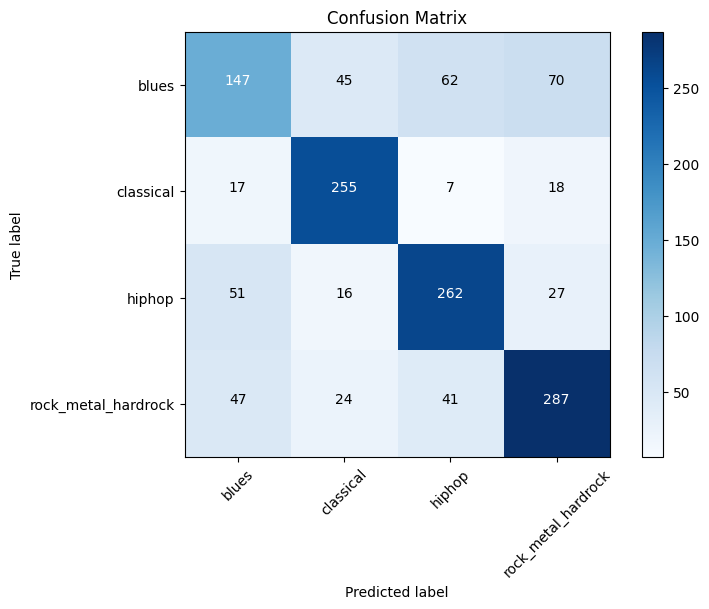

********************Training while using cuda********************
Fully_Connected_NN(
  (linear): Sequential(
    (0): Linear(in_features=26, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=4, bias=True)
  )
)

--------------------Epoch 1/30--------------------
loss=1.437276,  [    0/ 3200]
loss=1.379164,  [  640/ 3200]
loss=1.370320,  [ 1280/ 3200]
loss=1.388556,  [ 1920/ 3200]
loss=1.183285,  [ 2560/ 3200]

--------------------Epoch 2/30--------------------
loss=1.123106,  [    0/ 3200]
loss=1.204639,  [  640/ 3200]
loss=1.143310,  [ 1280/ 3200]
loss=1.276371,  [ 1920/ 3200]
loss=1.310595,  [ 2560/ 3200]

--------------------Epoch 3/30--------------------
loss=1.146151,  [    0/ 3200]
loss=1.128708,  [  640/ 3200]
loss=1.007516,  [ 1280/ 3200]
loss=0.964900,  [ 1920/ 3200]
loss=0.954094,  [ 2560/ 3200]

--------------------Epoch 4/30--------------------
loss=0.901753,  [    0/ 3200]
loss=0.961531, 

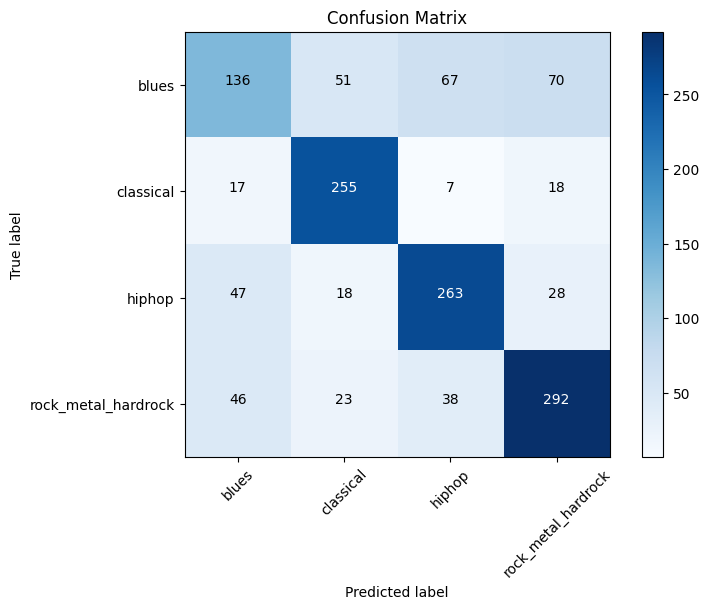

In [16]:
devices = [torch.device('cpu'), device]

for current_device in devices: # Loop for CPU & GPU training time comparison

    print(20*'*'+f'Training while using {current_device}'+20*'*')
    # Initiallizing the Neural Network
    model = Fully_Connected_NN().to(current_device)
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
    print(model)

    # Model Training
    start = time.time()
    NN_Training(num_epochs, optimizer, train_dataloader, loss_fn, model, current_device)
    finish = time.time()
    elapsed = finish - start
    print(f'\nElapsed time for training while using {current_device}: {elapsed:.4f} seconds\n')

    # Model Testing
    NN_testing(test_dataloader, loss_fn, model, current_device)


The current model's performance, with a macro F1 score around 68%, is suboptimal. The minor differences in accuracy and F1 score between the CPU and GPU implementations are probably due to the different weight initializations. Notably, the model struggles to correctly predict blues music samples, suggesting that a more complex architecture may be needed to better capture the patterns of this specific class.

Regarding training time comparisons, the outcomes are similar, with the GPU being slightly slower. This is likely due to the overhead of transferring data to the GPU. We expect to see more significant time savings with the GPU when incorporating a more complex architecture in our model.

## Model Training while evaluating on the validation set


--------------------Epoch 1/30--------------------
loss=1.391096,  [    0/ 3200]
loss=1.428825,  [  640/ 3200]
loss=1.331298,  [ 1280/ 3200]
loss=1.344030,  [ 1920/ 3200]
loss=1.096839,  [ 2560/ 3200]

Macro F1 score for the validation set: 0.452773

--------------------Epoch 2/30--------------------
loss=1.245400,  [    0/ 3200]
loss=1.068307,  [  640/ 3200]
loss=1.150261,  [ 1280/ 3200]
loss=1.037539,  [ 1920/ 3200]
loss=1.139582,  [ 2560/ 3200]

Macro F1 score for the validation set: 0.533002

--------------------Epoch 3/30--------------------
loss=1.195877,  [    0/ 3200]
loss=1.122791,  [  640/ 3200]
loss=1.089032,  [ 1280/ 3200]
loss=0.945781,  [ 1920/ 3200]
loss=0.829944,  [ 2560/ 3200]

Macro F1 score for the validation set: 0.544745

--------------------Epoch 4/30--------------------
loss=1.076165,  [    0/ 3200]
loss=0.940609,  [  640/ 3200]
loss=0.908794,  [ 1280/ 3200]
loss=1.090829,  [ 1920/ 3200]
loss=1.223205,  [ 2560/ 3200]

Macro F1 score for the validation set: 0.550

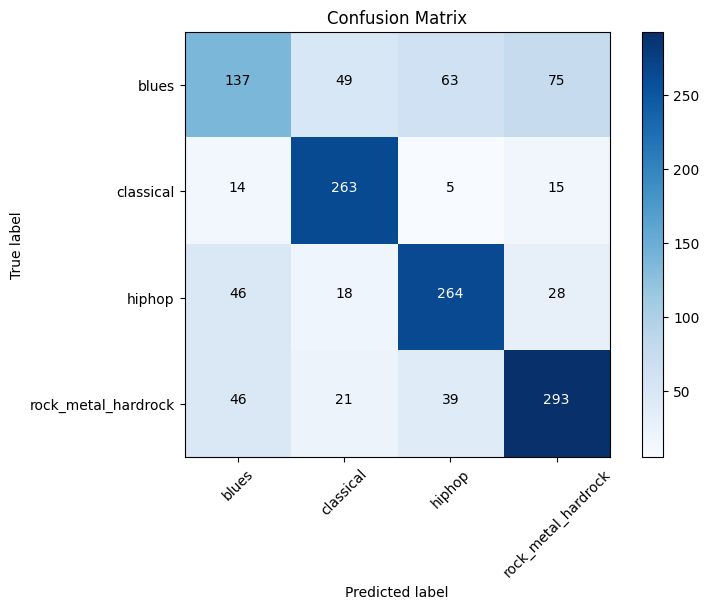

In [17]:
# Initializing the Neural Net
model = Fully_Connected_NN()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

# Model Training & extraction of the best performing model on the validation set w.r.t. the f1 score
best_model = NN_Training(num_epochs, optimizer, train_dataloader, loss_fn, model,
                         torch.device('cpu'), validation=True, val_dataloader=val_dataloader)

# Model Testing
NN_testing(test_dataloader, loss_fn, best_model, torch.device('cpu'))

To improve our model's performance, we used the validation set as a reference point for different instances of our model during training. We retained the instance that achieves the highest macro F1 score on the validation set.

While the results show slight improvement, it is evident that a more complex architecture is needed to effectively capture the hidden patterns within the data.

# Question 2: Convolutional Neural Network

## Data Loading

In [80]:
X_train, Y_train = Data_loading('train', 'melgrams')
X_val, Y_val = Data_loading('val', 'melgrams')
X_test, Y_test = Data_loading('test', 'melgrams')

Music gernes in train set: ['blues' 'classical' 'hiphop' 'rock_metal_hardrock']
Corresponding counts: [800 800 800 800]
Corresponding labels: [0 1 2 3]
Music gernes in val set: ['blues' 'classical' 'hiphop' 'rock_metal_hardrock']
Corresponding counts: [200 200 200 200]
Corresponding labels: [0 1 2 3]
Music gernes in test set: ['blues' 'classical' 'hiphop' 'rock_metal_hardrock']
Corresponding counts: [324 297 356 399]
Corresponding labels: [0 1 2 3]


## Plotting one random melgram from each class

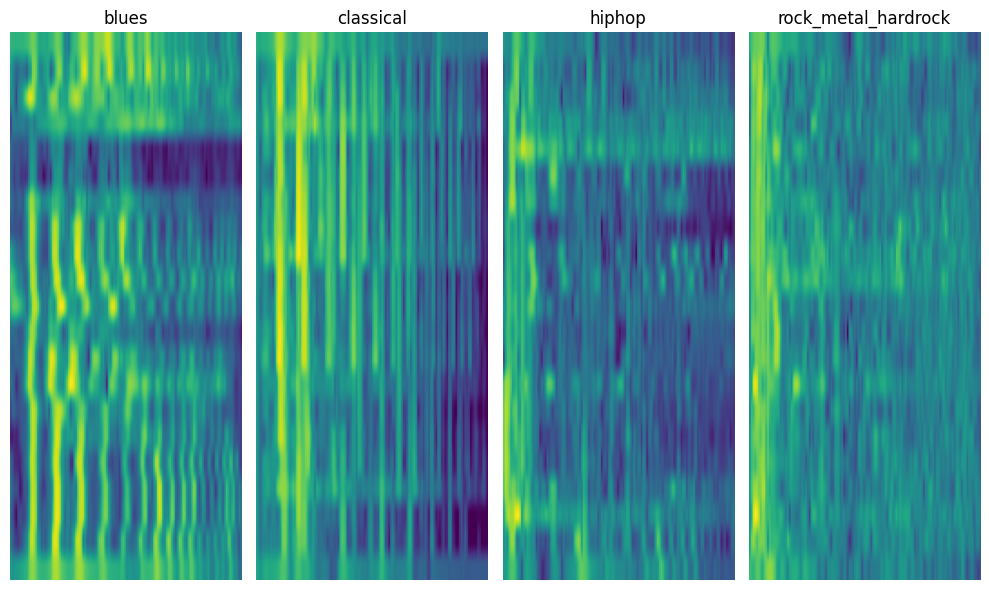

In [ ]:
classes = ['blues', 'classical', 'hiphop', 'rock_metal_hardrock']
labels = np.unique(Y_train)
plt.figure(figsize=(10, 6))

for i, (cls, label) in enumerate(zip(classes, labels)):
    indices = np.where(Y_train == label)[0]
    random_index = np.random.choice(indices)
    spectrogram = X_train[random_index]

    plt.subplot(1, len(classes), i + 1)
    plt.imshow(spectrogram, aspect='auto', origin='lower')
    plt.title(cls)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Data Preparation

In [81]:
# Normalizing
X_train = matrix_normalizer(X_train, 'melgrams')
X_val = matrix_normalizer(X_val, 'melgrams')
X_test = matrix_normalizer(X_test, 'melgrams')

# Adding a channel dimension to get shape [3200, 1, 21, 128]
X_train = X_train.unsqueeze(1)
X_val = X_val.unsqueeze(1)
X_test = X_test.unsqueeze(1)

# Loading to Pytorch DataLoaders
trainset = TensorDataset(X_train, Y_train)
train_dataloader = DataLoader(trainset, batch_size=16, shuffle=True)

valset = TensorDataset(X_val, Y_val)
val_dataloader = DataLoader(valset, batch_size=16, shuffle=True)

testset = TensorDataset(X_test, Y_test)
test_dataloader = DataLoader(testset, batch_size=16, shuffle=False)

print('Shape of the input data: [number of samples, channels, height, width]')
print(f'X_train shape: {X_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'X_test shape: {X_test.shape}')

Shape of the input data: [number of samples, channels, height, width]
X_train shape: torch.Size([3200, 1, 21, 128])
X_val shape: torch.Size([800, 1, 21, 128])
X_test shape: torch.Size([1376, 1, 21, 128])


## Convolutional Neural Network

In [20]:
class Base_CNN(nn.Module):
    def __init__(self):
        super(Base_CNN, self).__init__()
        # in_channels, out_channels, kernel_size
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 5)
        self.conv4 = nn.Conv2d(64, 128, 5)

        # input_size, output_size
        self.dense1 = nn.Linear(128 * 5 * 112, 1024)
        self.dense2 = nn.Linear(1024, 256)
        self.dense3 = nn.Linear(256, 32)
        self.dense4 = nn.Linear(32, 4)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        # Flattenning the tensor from [batch_size, channels, height, width]
        #                          to [batch_size, channels * height * width]
        x = x.view(x.size(0), -1)

        # Applying fully connected layers
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)

        return x

## CPU vs. GPU elapsed training time

Training with CPU

********************Training while using cpu********************
Base_CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (dense1): Linear(in_features=71680, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=32, bias=True)
  (dense4): Linear(in_features=32, out_features=4, bias=True)
)

--------------------Epoch 1/30--------------------
loss=1.407873,  [    0/ 3200]
loss=1.379332,  [  640/ 3200]
loss=1.271225,  [ 1280/ 3200]
loss=1.322562,  [ 1920/ 3200]
loss=1.282577,  [ 2560/ 3200]

Macro F1 score for the validation set: 0.424277

--------------------Epoch 2/30--------------------
loss=1.201918,  [    0/ 3200]
loss=1.189601,  [  640/ 3200]
loss=1.163894,  [ 1280/ 3200]
loss=0.907304,  [ 1920/ 32

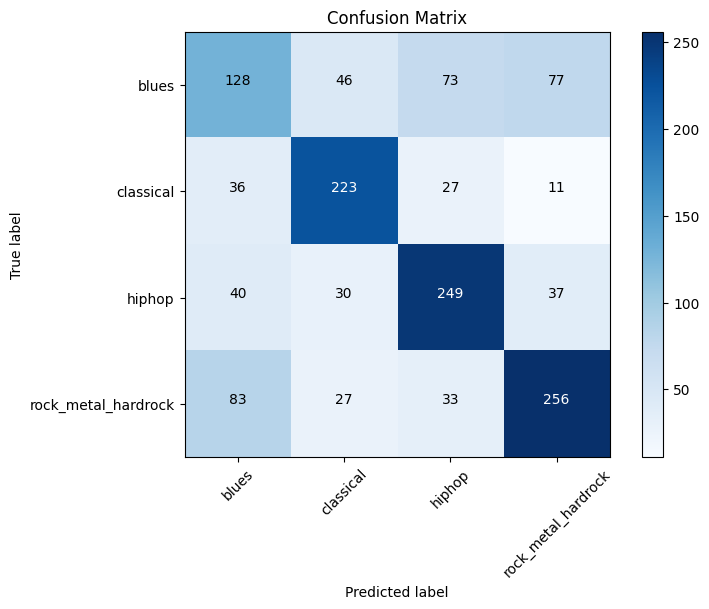

In [ ]:
current_device = torch.device('cpu')
print(20*'*'+f'Training while using {current_device}'+20*'*')

# Initiallizing the Neural Network
model = Base_CNN().to(current_device)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
print(model)

# Model Training
start = time.time()
best_model = NN_Training(num_epochs, optimizer, train_dataloader, loss_fn, model,
                         current_device, validation=True, val_dataloader=val_dataloader)
finish = time.time()
elapsed = (finish - start) / 60
print(f'\nElapsed time for training while using {current_device}: {elapsed:.4f} minutes\n')

# Model Testing
NN_testing(test_dataloader, loss_fn, best_model, current_device)

We notice that training this model using a CPU is a much more time-consuming process, due to the increased number of parameters. The entire training procedure took over 1.5 hours and yielded worse results than those obtained with the Feed Forward approach. The latter suggests that we should explore common techniques used in CNNs, such as max pooling and padding, while also experimenting with different optimizers, activation functions and regularization techniques to effectively harness the model's capabilities.

Training with GPU

********************Training while using cuda********************
Base_CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (dense1): Linear(in_features=71680, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=32, bias=True)
  (dense4): Linear(in_features=32, out_features=4, bias=True)
)

--------------------Epoch 1/30--------------------
loss=1.408939,  [    0/ 3200]
loss=1.344981,  [  640/ 3200]
loss=1.257147,  [ 1280/ 3200]
loss=1.297744,  [ 1920/ 3200]
loss=0.944145,  [ 2560/ 3200]

Macro F1 score for the validation set: 0.566578

--------------------Epoch 2/30--------------------
loss=0.824860,  [    0/ 3200]
loss=1.089267,  [  640/ 3200]
loss=0.870164,  [ 1280/ 3200]
loss=0.828398,  [ 1920/ 3

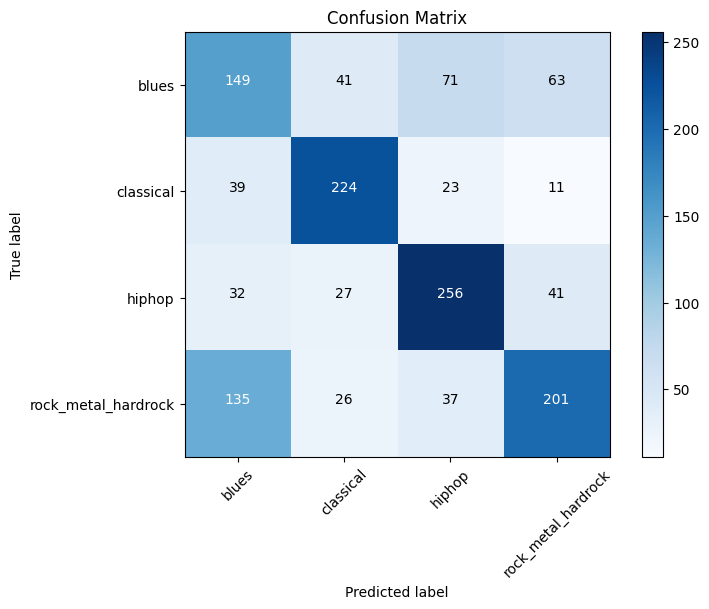

In [21]:
current_device = device
print(20*'*'+f'Training while using {current_device}'+20*'*')

# Initiallizing the Neural Network
model = Base_CNN().to(current_device)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
print(model)

# Model Training
start = time.time()
best_model = NN_Training(num_epochs, optimizer, train_dataloader, loss_fn, model, current_device, validation=True, val_dataloader=val_dataloader)
finish = time.time()
elapsed = (finish - start) / 60
print(f'\nElapsed time for training while using {current_device}: {elapsed:.4f} minutes\n')

# Model Testing
NN_testing(test_dataloader, loss_fn, best_model, current_device)

In this case, it is obvious that using GPU significantly decreases training time, as it takes only 2 minutes to train our CNN. This improvement is due to the GPU's parallel computation capabilities, which are highly effective for the matrix operations involved in training the model's parameters. Of course the overhead of transferring data to the GPU is still present, but this is minor compared to the overall time saved by parallelizing the training process.

## Convolutional Neural Net with Max Pooling and Padding of 2 elements

In this attempt, we are implementing padding of 2 elements in our model to increase the effective input size, allowing the convolution operation to cover the border regions more effectively. We are also incorporating max pooling, a downsampling operation used in CNNs to reduce the spatial dimensions (height and width) of the input while retaining the most important features.

In [60]:
class CNN_MP(nn.Module):
    def __init__(self):
        super(CNN_MP, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, 5, padding=2)
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
        self.conv4 = nn.Conv2d(64, 128, 5, padding=2)

        # Max pooling layer with kernel size 2
        self.max_pool = nn.MaxPool2d(2)

        # Calculate the size of the input for the first dense layer
        # The output size after the conv and pool layers
        # Input: [1, 21, 128]
        # -> conv1 -> [16, 21, 128] -> pool -> [16, 10, 64]
        # -> conv2 -> [32, 10, 64] -> pool -> [32, 5, 32]
        # -> conv3 -> [64, 5, 32] -> pool -> [64, 2, 16]
        # -> conv4 -> [128, 2, 16] -> pool -> [128, 1, 8]
        self.dense1 = nn.Linear(128 * 1 * 8, 1024)
        self.dense2 = nn.Linear(1024, 256)
        self.dense3 = nn.Linear(256, 32)
        self.dense4 = nn.Linear(32, 4)

    def forward(self, x):
        x = self.max_pool(self.conv1(x))
        x = self.max_pool(self.conv2(x))
        x = self.max_pool(self.conv3(x))
        x = self.max_pool(self.conv4(x))

        x = x.view(x.size(0), -1)

        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)

        return x


Training

********************Training while using cuda********************
CNN_MP(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dense1): Linear(in_features=1024, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=32, bias=True)
  (dense4): Linear(in_features=32, out_features=4, bias=True)
)

--------------------Epoch 1/30--------------------
loss=1.390236,  [    0/ 3200]
loss=1.387902,  [  640/ 3200]
loss=1.417627,  [ 1280/ 3200]
loss=1.386124,  [ 1920/ 3200]
loss=1.365537,  [ 2560/ 3200]

Macro F1 score for the validation set: 0.241705

----------------

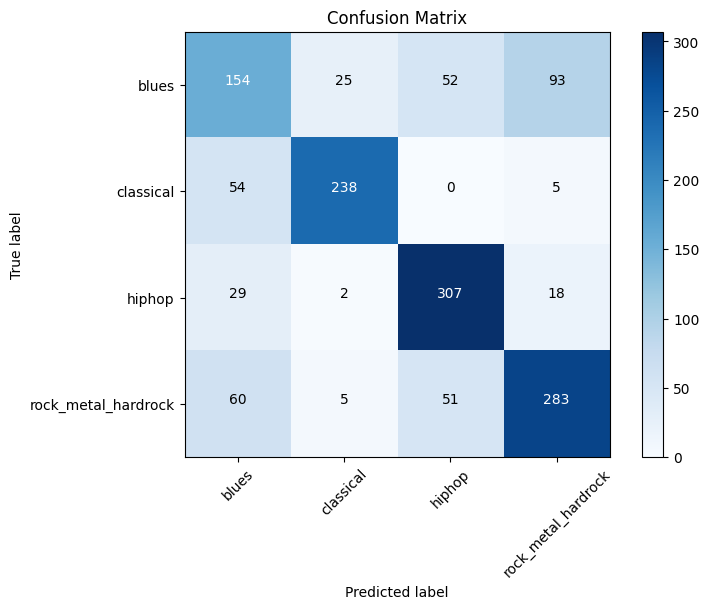

In [23]:
current_device = device
print(20*'*'+f'Training while using {current_device}'+20*'*')

# Initiallizing the Neural Network
model = CNN_MP().to(current_device)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
print(model)

# Model Training
start = time.time()
best_model = NN_Training(num_epochs, optimizer, train_dataloader, loss_fn, model, current_device, validation=True, val_dataloader=val_dataloader)
finish = time.time()
elapsed = (finish - start) / 60
print(f'\nElapsed time for training while using {current_device}: {elapsed:.4f} minutes\n')

# Model Testing
NN_testing(test_dataloader, loss_fn, best_model, current_device)

We notice that the training time decreased to nearly one-third of the previous duration. This reduction in training time is primarily due to Max Pooling reducing the size of the feature maps, thereby resulting in fewer computations in subsequent layers. Moreover, we observe a significant increase in performance, with the macro F1 score improving from 61% to 71%. This indicates that the critical information retained during the Max Pooling process is helping the model make more accurate predictions. Additionally, introducing padding, which typically preserves edge and boundary information and maintains larger feature map sizes through more layers, contributed to this performance improvement by ensuring that important spatial features are not lost during the pooling operation.

## Experimenting with various optimizers

********************Training while using cuda with Adam optimizer********************
CNN_MP(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dense1): Linear(in_features=1024, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=32, bias=True)
  (dense4): Linear(in_features=32, out_features=4, bias=True)
)

--------------------Epoch 1/30--------------------
loss=1.385967,  [    0/ 3200]
loss=1.584406,  [  640/ 3200]
loss=0.402872,  [ 1280/ 3200]
loss=1.096061,  [ 1920/ 3200]
loss=0.931369,  [ 2560/ 3200]

Macro F1 score for the validation set: 0.7292

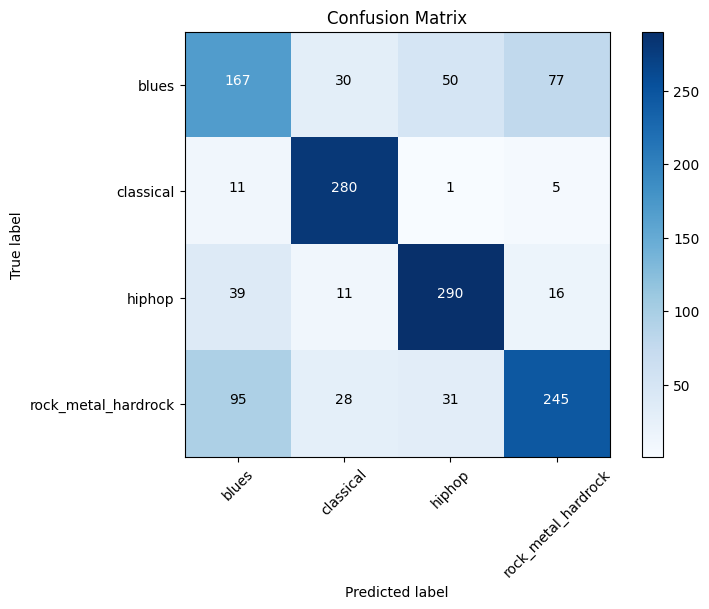

********************Training while using cuda with AdamW optimizer********************
CNN_MP(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dense1): Linear(in_features=1024, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=32, bias=True)
  (dense4): Linear(in_features=32, out_features=4, bias=True)
)

--------------------Epoch 1/30--------------------
loss=1.377088,  [    0/ 3200]
loss=1.252523,  [  640/ 3200]
loss=0.889286,  [ 1280/ 3200]
loss=0.997597,  [ 1920/ 3200]
loss=0.839769,  [ 2560/ 3200]

Macro F1 score for the validation set: 0.562

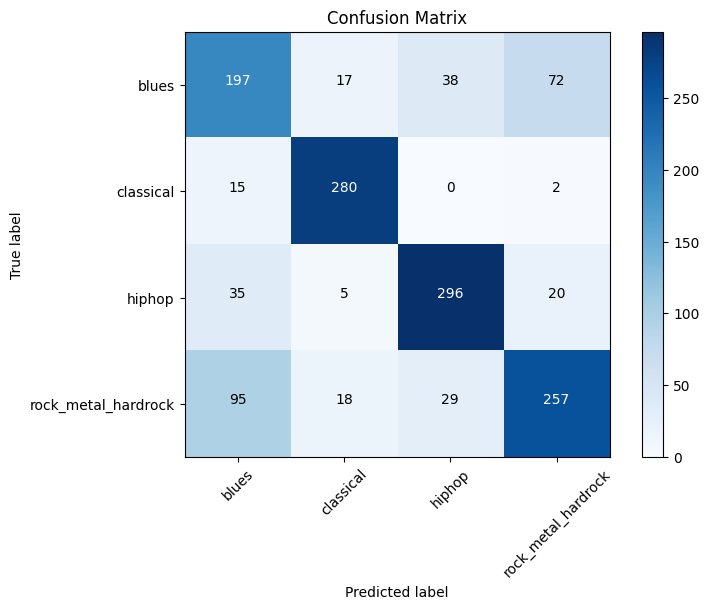

********************Training while using cuda with SGD optimizer********************
CNN_MP(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dense1): Linear(in_features=1024, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=32, bias=True)
  (dense4): Linear(in_features=32, out_features=4, bias=True)
)

--------------------Epoch 1/30--------------------
loss=1.401914,  [    0/ 3200]
loss=1.384531,  [  640/ 3200]
loss=1.393787,  [ 1280/ 3200]
loss=1.377959,  [ 1920/ 3200]
loss=1.393552,  [ 2560/ 3200]

Macro F1 score for the validation set: 0.11263

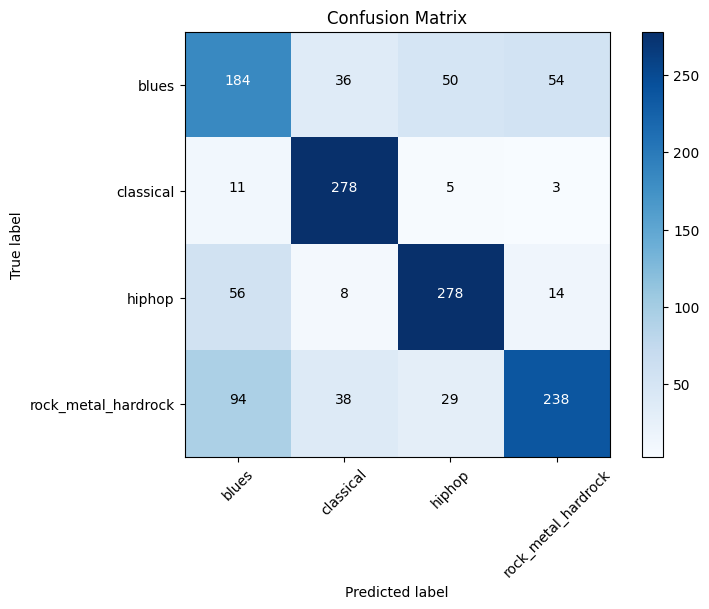

********************Training while using cuda with RMSprop optimizer********************
CNN_MP(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dense1): Linear(in_features=1024, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=32, bias=True)
  (dense4): Linear(in_features=32, out_features=4, bias=True)
)

--------------------Epoch 1/30--------------------
loss=1.316526,  [    0/ 3200]
loss=81.179649,  [  640/ 3200]
loss=19.131195,  [ 1280/ 3200]
loss=9.517226,  [ 1920/ 3200]
loss=5.123901,  [ 2560/ 3200]

Macro F1 score for the validation set: 0

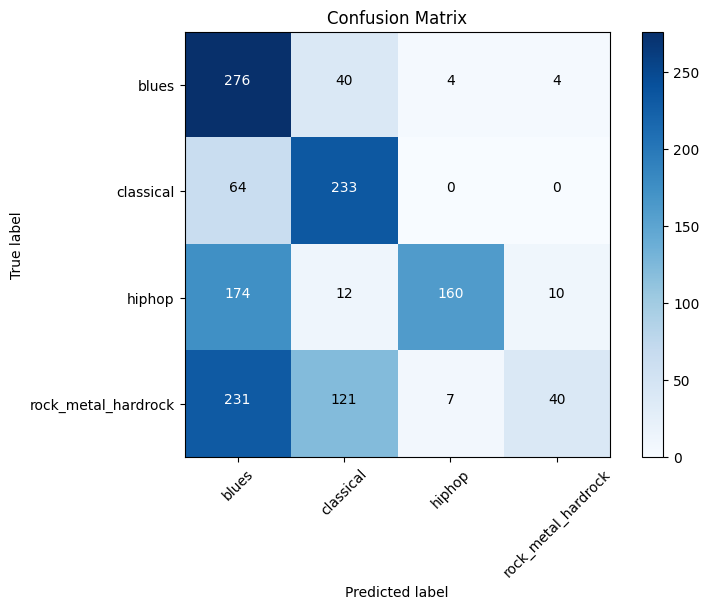

********************Training while using cuda with Adagrad optimizer********************
CNN_MP(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dense1): Linear(in_features=1024, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=32, bias=True)
  (dense4): Linear(in_features=32, out_features=4, bias=True)
)

--------------------Epoch 1/30--------------------
loss=1.396500,  [    0/ 3200]
loss=0.948929,  [  640/ 3200]
loss=1.006435,  [ 1280/ 3200]
loss=0.718862,  [ 1920/ 3200]
loss=0.749439,  [ 2560/ 3200]

Macro F1 score for the validation set: 0.7

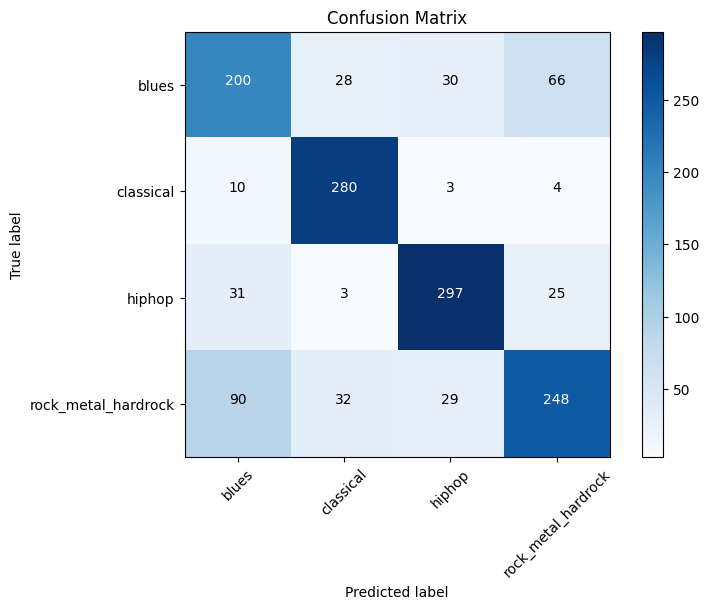


-------------------------Final results-------------------------
                          0          1          2          3          4
Optimizer              Adam      AdamW        SGD    RMSprop    Adagrad
Accuracy           0.713663   0.748547   0.710756   0.515262   0.744913
Macro F1           0.712278   0.751977   0.710759   0.490764    0.74623
Elapsed Time (s)  45.735646  45.858534  42.981876  45.053836  44.526632


In [25]:
# Dictionary of optimizers to compare
optimizers = {
    'Adam': torch.optim.Adam,
    'AdamW': torch.optim.AdamW,
    'SGD': torch.optim.SGD,
    'RMSprop': torch.optim.RMSprop,
    'Adagrad': torch.optim.Adagrad
}
# Dictionary for tracking the results
results = {
        'Optimizer': [],
        'Accuracy': [],
        'Macro F1': [],
        'Elapsed Time (s)': []
    }

for opt_name, opt_class in optimizers.items():
    print(20*'*'+f'Training while using {device} with {opt_name} optimizer'+20*'*')
    results['Optimizer'].append(opt_name)

    # Initiallizing the Neural Network
    model = CNN_MP().to(device)
    optimizer = opt_class(model.parameters(), lr = learning_rate)
    print(model)

    # Model Training
    start = time.time()
    best_model = NN_Training(num_epochs, optimizer, train_dataloader, loss_fn, model,
                             current_device, validation=True, val_dataloader=val_dataloader)
    finish = time.time()
    elapsed = finish - start
    print(f'\nElapsed time for training: {elapsed:.2f} seconds\n')
    results['Elapsed Time (s)'].append(elapsed)

    # Model Testing
    accuracy, f1 = NN_testing(test_dataloader, loss_fn, best_model, current_device, return_metrics=True)
    results['Accuracy'].append(accuracy)
    results['Macro F1'].append(f1)

results_df = pd.DataFrame(results)
# Invert columns and rows
inverted_results = results_df.transpose()
print('\n'+25*'-'+f'Final results'+25*'-')
print(inverted_results)

We notice that all the tested optimizers yield similar results, with the exception of RMSprop, which performs the poorest. Adam, AdamW, and Adagrad appear to converge faster, as they reach their best performance on the validation set in fewer epochs compared to SGD. Among them, AdamW performs the best, achieving a macro F1 score of 75%. This is likely due to AdamW's adaptive learning rates, which contribute to faster and more stable convergence. Regarding training times, all algorithms exhibited similar behavior. Considering these facts, we will use AdamW from now on.

# Question 3: Improving Performance

## Reproducibility

In this section, we ensure the deterministic behavior of our model's performance. To achieve this, we first seed all the libraries that we are going to use and then we reinitialize functions and hyperparameters.

It is crucial to perform these steps in the exact order every time we train our model to maintain reproducibility. This allows us to verify if any applied changes genuinely improve performance and are not influenced by randomness or initialization variations.

Seeding for Reproducibility

In [77]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

# Seed initialization for reproducibility
seed = 42
set_seed(seed)

First Training Attempt

********************Training while using cuda********************
CNN_MP(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dense1): Linear(in_features=1024, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=32, bias=True)
  (dense4): Linear(in_features=32, out_features=4, bias=True)
)

--------------------Epoch 1/30--------------------
loss=1.404881,  [    0/ 3200]
loss=0.733130,  [  640/ 3200]
loss=0.733334,  [ 1280/ 3200]
loss=1.097217,  [ 1920/ 3200]
loss=0.773174,  [ 2560/ 3200]

Macro F1 score for the validation set: 0.588332

----------------

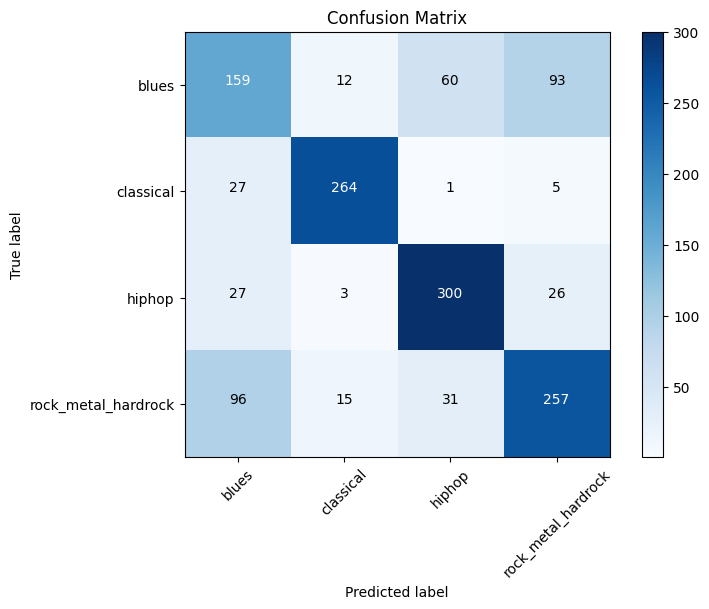

In [ ]:
# Device Selection
current_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(20*'*'+f'Training while using {current_device}'+20*'*')

# Initiallizing the Neural Network
model = CNN_MP().to(current_device)
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)
print(model)

# Model Training
best_model = NN_Training(num_epochs, optimizer, train_dataloader, loss_fn, model,
                         current_device, validation=True, val_dataloader=val_dataloader)

# Model Testing
NN_testing(test_dataloader, loss_fn, best_model, current_device)

Second Training Attempt

********************Training while using cuda********************
CNN_MP(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dense1): Linear(in_features=1024, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=32, bias=True)
  (dense4): Linear(in_features=32, out_features=4, bias=True)
)

--------------------Epoch 1/30--------------------
loss=1.404881,  [    0/ 3200]
loss=0.733130,  [  640/ 3200]
loss=0.733334,  [ 1280/ 3200]
loss=1.097217,  [ 1920/ 3200]
loss=0.773174,  [ 2560/ 3200]

Macro F1 score for the validation set: 0.588332

----------------

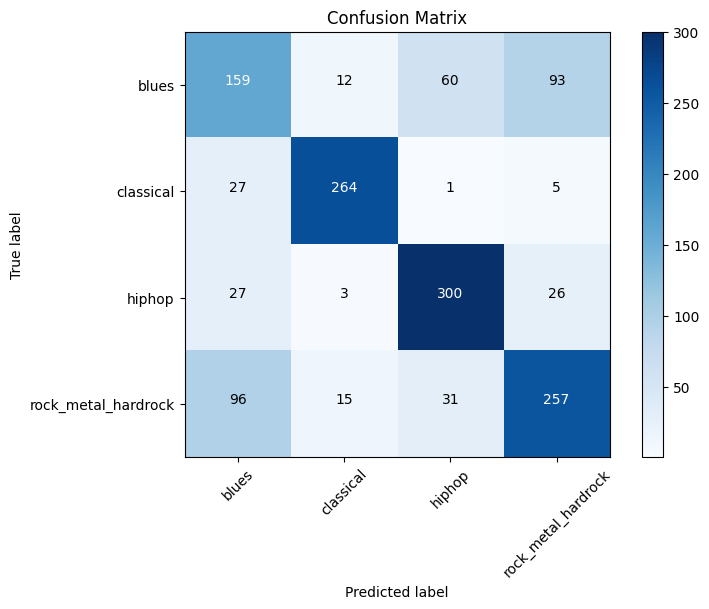

In [ ]:
# Device Selection
current_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(20*'*'+f'Training while using {current_device}'+20*'*')

# Initiallizing the Neural Network
model = CNN_MP().to(current_device)
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)
print(model)

# Model Training
best_model = NN_Training(num_epochs, optimizer, train_dataloader, loss_fn, model,
                         current_device, validation=True, val_dataloader=val_dataloader)

# Model Testing
NN_testing(test_dataloader, loss_fn, best_model, current_device)

We observe that we have achieved the desired deterministic behavior, as both the loss values across different batches and the final macro f1 score (71.4%) are the same in the two training attempts. In our subsequent experiments, we will continue to use the same seeding procedure and we will have this f1 score as a baseline for comparisons.

## Activations Functions

In this section we explore the impact of some activation functions, as we seek to improve our model's performance. The introduction of activation functions is essential in introducing non-linearity, enabling our model to learn complex patterns and enhancing its performance compared to a linear baseline.

Convolutional Neural Network with Max Pooling, Padding and Activation Functions

In [82]:
class CNN_MP_Activ(nn.Module):
    def __init__(self, act_function):
        super(CNN_MP_Activ, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, 5, padding=2)
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
        self.conv4 = nn.Conv2d(64, 128, 5, padding=2)

        self.max_pool = nn.MaxPool2d(2)

        self.dense1 = nn.Linear(128 * 1 * 8, 1024)
        self.dense2 = nn.Linear(1024, 256)
        self.dense3 = nn.Linear(256, 32)
        self.dense4 = nn.Linear(32, 4)

        self.activation_function = act_function

    def forward(self, x):
        activation = self.activation_function

        x = self.max_pool(activation(self.conv1(x)))
        x = self.max_pool(activation(self.conv2(x)))
        x = self.max_pool(activation(self.conv3(x)))
        x = self.max_pool(activation(self.conv4(x)))

        x = x.view(x.size(0), -1)

        x = activation(self.dense1(x))
        x = activation(self.dense2(x))
        x = activation(self.dense3(x))
        x = self.dense4(x)

        return x

Dictionary for tracking the results

In [62]:
results = {
        'Activation function': [],
        'Accuracy': [],
        'Macro F1': []
    }

ReLu

********************Training while using cuda with ReLu activation function********************
CNN_MP_Activ(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dense1): Linear(in_features=1024, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=32, bias=True)
  (dense4): Linear(in_features=32, out_features=4, bias=True)
)

--------------------Epoch 1/30--------------------
loss=1.400117,  [    0/ 3200]
loss=1.232341,  [  640/ 3200]
loss=1.142937,  [ 1280/ 3200]
loss=1.027811,  [ 1920/ 3200]
loss=0.991495,  [ 2560/ 3200]

Macro F1 score for the valida

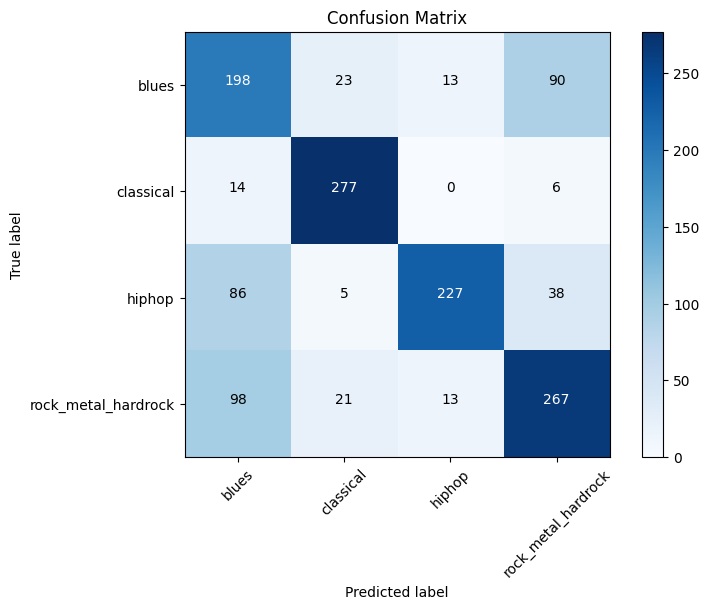

In [ ]:
act_name = 'ReLu'
act_class = F.relu

# Device Selection
current_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(20*'*'+f'Training while using {current_device} with {act_name} activation function'+20*'*')
results['Activation function'].append(act_name)

# Initiallizing the Neural Network
model = CNN_MP_Activ(act_class).to(current_device)
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)
print(model)

# Model Training
best_model = NN_Training(num_epochs, optimizer, train_dataloader, loss_fn, model,
                         current_device, validation=True, val_dataloader=val_dataloader)

# Model Testing
accuracy, f1 = NN_testing(test_dataloader, loss_fn, best_model, current_device, return_metrics=True)
results['Accuracy'].append(accuracy)
results['Macro F1'].append(f1)

SeLu

********************Training while using cuda with SeLu activation function********************
CNN_MP_Activ(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dense1): Linear(in_features=1024, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=32, bias=True)
  (dense4): Linear(in_features=32, out_features=4, bias=True)
)

--------------------Epoch 1/30--------------------
loss=1.404082,  [    0/ 3200]
loss=1.185050,  [  640/ 3200]
loss=0.919147,  [ 1280/ 3200]
loss=1.432964,  [ 1920/ 3200]
loss=1.296614,  [ 2560/ 3200]

Macro F1 score for the valida

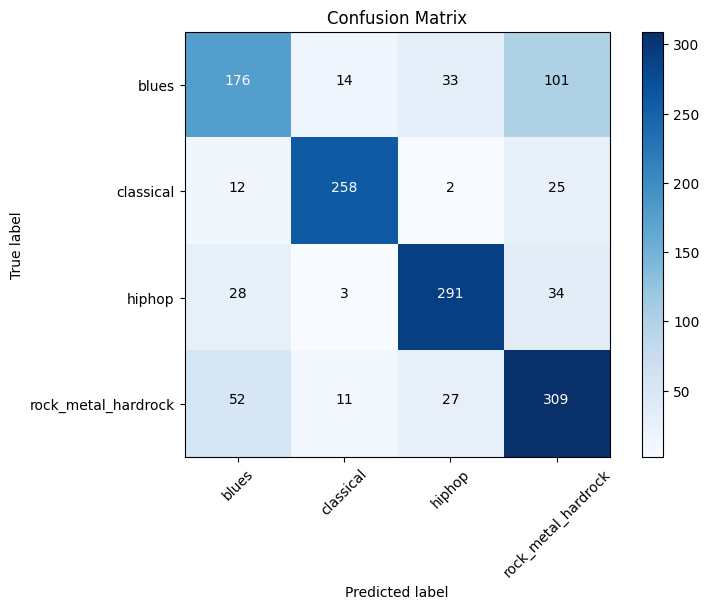

In [ ]:
act_name = 'SeLu'
act_class = F.selu

# Device Selection
current_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(20*'*'+f'Training while using {current_device} with {act_name} activation function'+20*'*')
results['Activation function'].append(act_name)

# Initiallizing the Neural Network
model = CNN_MP_Activ(act_class).to(current_device)
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)
print(model)

# Model Training
best_model = NN_Training(num_epochs, optimizer, train_dataloader, loss_fn, model,
                         current_device, validation=True, val_dataloader=val_dataloader)

# Model Testing
accuracy, f1 = NN_testing(test_dataloader, loss_fn, best_model, current_device, return_metrics=True)
results['Accuracy'].append(accuracy)
results['Macro F1'].append(f1)

Tanh

********************Training while using cuda with tanh activation function********************
CNN_MP_Activ(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dense1): Linear(in_features=1024, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=32, bias=True)
  (dense4): Linear(in_features=32, out_features=4, bias=True)
)

--------------------Epoch 1/30--------------------
loss=1.403104,  [    0/ 3200]
loss=1.053128,  [  640/ 3200]
loss=1.178931,  [ 1280/ 3200]
loss=1.450952,  [ 1920/ 3200]
loss=1.182684,  [ 2560/ 3200]

Macro F1 score for the valida

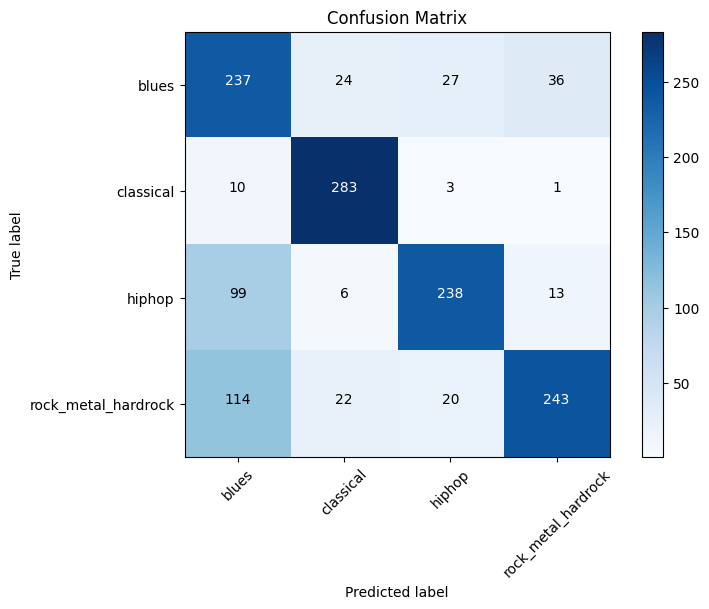

In [ ]:
act_name = 'tanh'
act_class = F.tanh

# Device Selection
current_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(20*'*'+f'Training while using {current_device} with {act_name} activation function'+20*'*')
results['Activation function'].append(act_name)

# Initiallizing the Neural Network
model = CNN_MP_Activ(act_class).to(current_device)
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)
print(model)

# Model Training
best_model = NN_Training(num_epochs, optimizer, train_dataloader, loss_fn, model,
                         current_device, validation=True, val_dataloader=val_dataloader)

# Model Testing
accuracy, f1 = NN_testing(test_dataloader, loss_fn, best_model, current_device, return_metrics=True)
results['Accuracy'].append(accuracy)
results['Macro F1'].append(f1)

In [ ]:
results_df = pd.DataFrame(results)
# Invert columns and rows
inverted_results = results_df.transpose()
print('\n'+20*'-'+f'Final results'+20*'-')
print(inverted_results)


--------------------Final results--------------------
                            0         1         2
Activation function      ReLu      SeLu      tanh
Accuracy             0.704215  0.751453  0.727471
Macro F1             0.713057  0.753132  0.735401


In our exploration of different activation functions within our CNN architecture, we began by seeding our experiments to eliminate randomness and ensure consistent comparisons. We tested SELU, ReLU, and Tanh, and observed some interesting results regarding model performance.

Considering that the macro F1 score without any activation function was 71.4%, SELU showed the most significant improvement, increasing the score to 75.3%. This is likely attributed to SELU's self-normalizing properties, which maintain stable gradients throughout training and enhance generalization capabilities. In contrast, ReLU demonstrated a minor decrease in performance, probably because it lacks automatic normalization, which may lead to less stable training dynamics and result in decrease in performance (F1 score 71.3%). On the other hand, Tanh's ability to center data within the range of -1 to 1 proved crucial, as it has improved perfomance to 73.5%. For our upcoming experiments, we will adopt SELU as our preferred activation function.

## Learning rate schedulers

In this section we experiment with various learing rate schedulers.

Dictionary for tracking the results

In [ ]:
results = {
        'Scheduler': [],
        'Accuracy': [],
        'Macro F1': []
    }

StepLR Scheduler

********************Training while using cuda with StepLR learing rate scheduler********************
Adjusting learning rate of group 0 to 2.0000e-03.
CNN_MP_Activ(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dense1): Linear(in_features=1024, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=32, bias=True)
  (dense4): Linear(in_features=32, out_features=4, bias=True)
)

--------------------Epoch 1/30--------------------
loss=1.404082,  [    0/ 3200]
loss=1.185050,  [  640/ 3200]
loss=0.919147,  [ 1280/ 3200]
loss=1.432964,  [ 1920/ 3200]
loss=

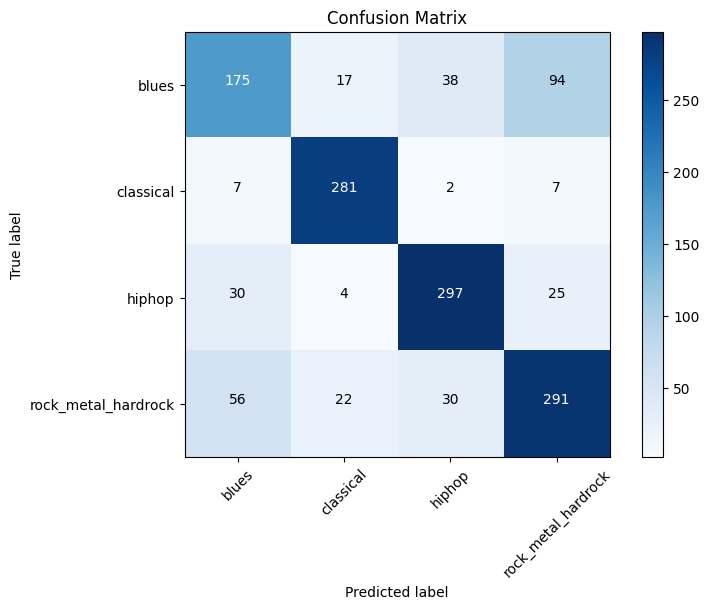

In [ ]:
# Scheduler selection
scheduler_name = 'StepLR'
scheduler_class = torch.optim.lr_scheduler.StepLR
results['Scheduler'].append(scheduler_name)

# Activation function selection
act_name = 'SeLu'
act_class = F.selu

# Device Selection
current_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(20*'*'+f'Training while using {current_device} with {scheduler_name} learing rate scheduler'+20*'*')

# Initiallizing the Neural Network
model = CNN_MP_Activ(act_class).to(current_device)
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)
scheduler = scheduler_class(optimizer, step_size=5, gamma=0.5, verbose=True)
print(model)

# Model Training
best_model = NN_Training(num_epochs, optimizer, train_dataloader, loss_fn, model,
                         current_device, validation=True, val_dataloader=val_dataloader, scheduler=scheduler)

# Model Testing
accuracy, f1 = NN_testing(test_dataloader, loss_fn, best_model, current_device, return_metrics=True)
results['Accuracy'].append(accuracy)
results['Macro F1'].append(f1)

MultiStepLR Scheduler

********************Training while using cuda with MultiStepLR learing rate scheduler********************
Adjusting learning rate of group 0 to 2.0000e-03.
CNN_MP_Activ(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dense1): Linear(in_features=1024, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=32, bias=True)
  (dense4): Linear(in_features=32, out_features=4, bias=True)
)

--------------------Epoch 1/30--------------------
loss=1.404082,  [    0/ 3200]
loss=1.185050,  [  640/ 3200]
loss=0.919147,  [ 1280/ 3200]
loss=1.432964,  [ 1920/ 3200]


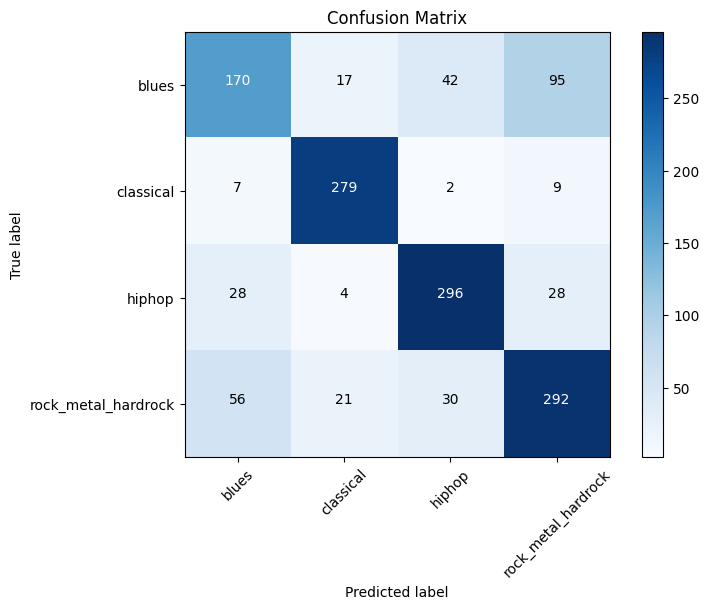

In [ ]:
# Scheduler selection
scheduler_name = 'MultiStepLR'
scheduler_class = torch.optim.lr_scheduler.MultiStepLR
results['Scheduler'].append(scheduler_name)

# Activation function selection
act_name = 'SeLu'
act_class = F.selu

# Device Selection
current_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(20*'*'+f'Training while using {current_device} with {scheduler_name} learing rate scheduler'+20*'*')

# Initiallizing the Neural Network
model = CNN_MP_Activ(act_class).to(current_device)
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)
scheduler = scheduler_class(optimizer, milestones=[5, 10, 15], gamma=0.5, verbose=True)
print(model)

# Model Training
best_model = NN_Training(num_epochs, optimizer, train_dataloader, loss_fn, model,
                         current_device, validation=True, val_dataloader=val_dataloader, scheduler=scheduler)

# Model Testing
accuracy, f1 = NN_testing(test_dataloader, loss_fn, best_model, current_device, return_metrics=True)
results['Accuracy'].append(accuracy)
results['Macro F1'].append(f1)

ReduceLROnPlateau Scheduler

********************Training while using cuda with ReduceLROnPlateau learing rate scheduler********************
CNN_MP_Activ(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dense1): Linear(in_features=1024, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=32, bias=True)
  (dense4): Linear(in_features=32, out_features=4, bias=True)
)

--------------------Epoch 1/30--------------------
loss=1.404082,  [    0/ 3200]
loss=1.185050,  [  640/ 3200]
loss=0.919147,  [ 1280/ 3200]
loss=1.432964,  [ 1920/ 3200]
loss=1.296614,  [ 2560/ 3200]

Macro F1 scor

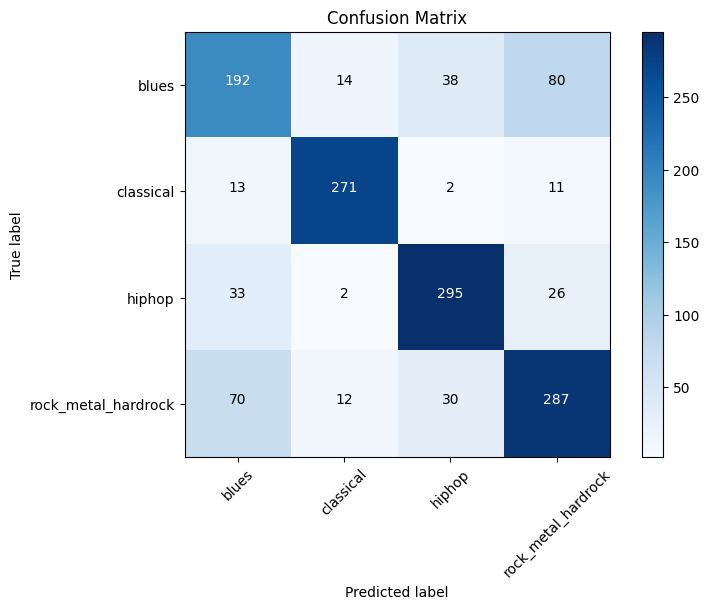

In [ ]:
# Scheduler selection
scheduler_name = 'ReduceLROnPlateau'
scheduler_class = torch.optim.lr_scheduler.ReduceLROnPlateau
results['Scheduler'].append(scheduler_name)

# Activation function selection
act_name = 'SeLu'
act_class = F.selu

# Device Selection
current_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(20*'*'+f'Training while using {current_device} with {scheduler_name} learing rate scheduler'+20*'*')

# Initiallizing the Neural Network
model = CNN_MP_Activ(act_class).to(current_device)
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)
scheduler = scheduler_class(optimizer, mode='min', patience=3, factor=0.1, verbose=True)
print(model)

# Model Training
best_model = NN_Training(num_epochs, optimizer, train_dataloader, loss_fn, model,
                         current_device, validation=True, val_dataloader=val_dataloader, scheduler=scheduler)

# Model Testing
accuracy, f1 = NN_testing(test_dataloader, loss_fn, best_model, current_device, return_metrics=True)
results['Accuracy'].append(accuracy)
results['Macro F1'].append(f1)

In [ ]:
results_df = pd.DataFrame(results)
# Invert columns and rows
inverted_results = results_df.transpose()
print('\n'+20*'-'+f'Final results'+20*'-')
print(inverted_results)


--------------------Final results--------------------
                  0            1                  2
Scheduler    StepLR  MultiStepLR  ReduceLROnPlateau
Accuracy   0.758721     0.753634           0.759448
Macro F1   0.757755     0.752284            0.76253


In our experiments, we tested three different learning rate schedulers: StepLR, MultiStepLR, and ReduceLROnPlateau.

1. StepLR: This scheduler reduces the learning rate by a factor of gamma every step_size epochs. This method introduces a fixed schedule for learning rate decay, which can help the model converge more smoothly by gradually reducing the learning rate, allowing for finer adjustments in the later stages of training.

2. MultiStepLR: This scheduler reduces the learning rate at specific epochs defined by a list of milestones. This approach provides more control over when the learning rate should be decreased, which can be beneficial if certain epochs are known to require finer adjustments based on prior experience.

3. ReduceLROnPlateau: This scheduler reduces the learning rate when a specified performance metric, such as the validation F1 score, stops improving. This adaptive approach dynamically adjusts the learning rate based on the model's performance, preventing the learning rate from being reduced prematurely or too aggressively.

In our experiments, a fixed learning rate of 2e-3 achieved a macro F1 score of 75.3%. Among the schedulers, ReduceLROnPlateau showed the most noticeable improvement, achieving a macro F1 score of 76.2%. By focusing on the validation F1 score, ReduceLROnPlateau ensures that the learning rate is only reduced when necessary, leading to more stable and potentially more effective training dynamics. This adaptiveness likely contributed to its superior performance in our experiments.

## Batch Normalization

In this section we introduce BatchNorm2d layers in our CNN model.

In [ ]:
class CNN_BatchNorm(nn.Module):
    def __init__(self):
        super(CNN_BatchNorm, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, 5, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 5, padding=2)
        self.bn4 = nn.BatchNorm2d(128)

        self.max_pool = nn.MaxPool2d(2)

        self.dense1 = nn.Linear(128 * 1 * 8, 1024)
        self.dense2 = nn.Linear(1024, 256)
        self.dense3 = nn.Linear(256, 32)
        self.dense4 = nn.Linear(32, 4)

        self.act_fn = nn.SELU()

    def forward(self, x):
        x = self.max_pool(self.act_fn(self.bn1(self.conv1(x))))
        x = self.max_pool(self.act_fn(self.bn2(self.conv2(x))))
        x = self.max_pool(self.act_fn(self.bn3(self.conv3(x))))
        x = self.max_pool(self.act_fn(self.bn4(self.conv4(x))))

        x = x.view(x.size(0), -1)

        x = self.act_fn(self.dense1(x))
        x = self.act_fn(self.dense2(x))
        x = self.act_fn(self.dense3(x))
        x = self.dense4(x)

        return x


********************Training while using cuda with ReduceLROnPlateau learing rate scheduler********************
CNN_BatchNorm(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dense1): Linear(in_features=1024, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=25

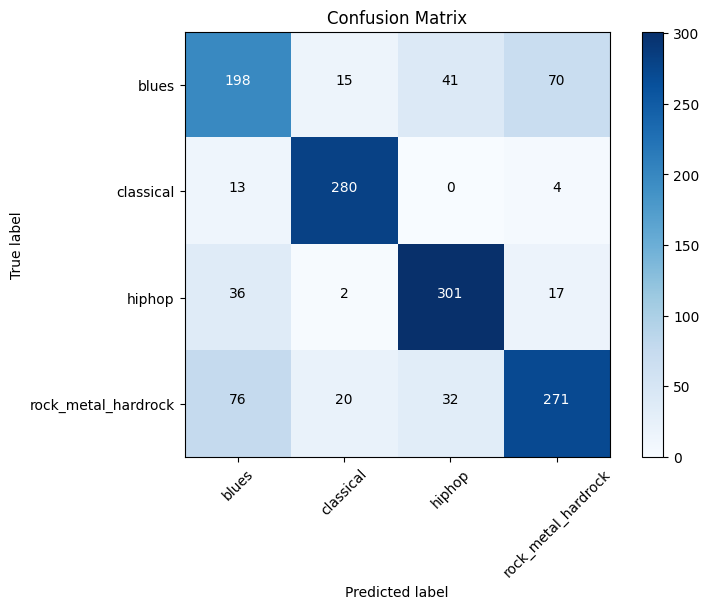

In [ ]:
# Scheduler selection
scheduler_name = 'ReduceLROnPlateau'
scheduler_class = torch.optim.lr_scheduler.ReduceLROnPlateau

# Device Selection
current_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(20*'*'+f'Training while using {current_device} with {scheduler_name} learing rate scheduler'+20*'*')

# Initiallizing the Neural Network
model = CNN_BatchNorm().to(current_device)
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)
scheduler = scheduler_class(optimizer, mode='min', patience=3, factor=0.1, verbose=True)
print(model)

# Model Training
best_model = NN_Training(num_epochs, optimizer, train_dataloader, loss_fn, model,
                         current_device, validation=True, val_dataloader=val_dataloader, scheduler=scheduler)

# Model Testing
NN_testing(test_dataloader, loss_fn, best_model, current_device)

We notice a slight improvement in performance with the introduction of BatchNorm2d layers, as the macro F1 score increased from 76.2% to 76.5%. BatchNorm2d normalizes the inputs of each mini-batch, stabilizing the learning process and often accelerating convergence by reducing internal covariate shift. This helps maintain the network's stability and performance during training, leading to more robust and consistent updates.

## Regularization

In this section, we conduct experiments using different weight decay values and apply dropout to the linear layers to assess their effects on model performance. Initially, we evaluate weight decay and dropout separately and compare their performances against the best achieved so far on the test set (76.5% macro f1 score). Subsequently, we combine the weight decay and dropout configurations in order to achieve the best possible results.

In [ ]:
num_epochs = 60

### Weight Decay Introduction

In [ ]:
# Searching space
weight_decay_values = [1e-4, 1e-3, 1e-2]

results = {
        'weight_decay_value': [],
        'Accuracy': [],
        'Macro F1': []
    }

********************Training while using cuda with 0.0001 weight_decay_value********************
CNN_BatchNorm(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dense1): Linear(in_features=1024, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
 

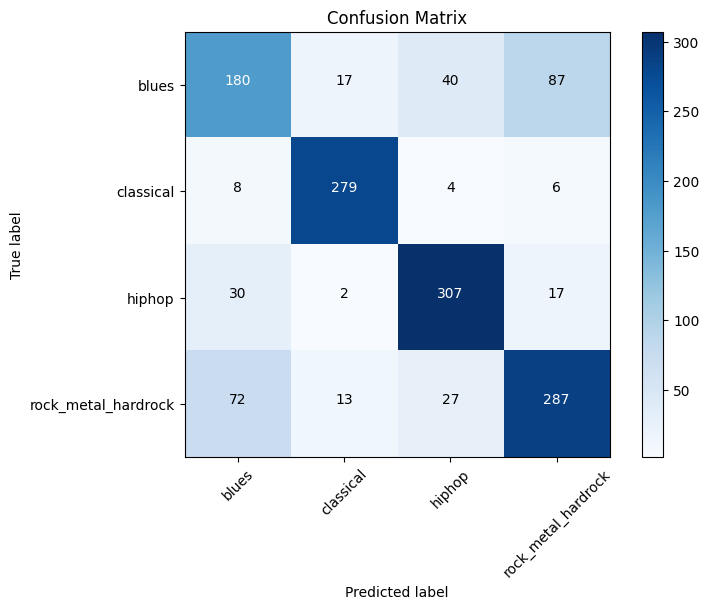

In [ ]:
weight_decay_value = 1e-4
results['weight_decay_value'].append(weight_decay_value)

# Scheduler selection
scheduler_name = 'ReduceLROnPlateau'
scheduler_class = torch.optim.lr_scheduler.ReduceLROnPlateau

# Device Selection
current_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(20*'*'+f'Training while using {current_device} with {weight_decay_value} weight_decay_value'+20*'*')

# Initiallizing the Neural Network
model = CNN_BatchNorm().to(current_device)
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate, weight_decay=weight_decay_value)
scheduler = scheduler_class(optimizer, mode='min', patience=3, factor=0.1, verbose=True)
print(model)

# Model Training
best_model = NN_Training(num_epochs, optimizer, train_dataloader, loss_fn, model,
                         current_device, validation=True, val_dataloader=val_dataloader, scheduler=scheduler)

# Model Testing
accuracy, f1 = NN_testing(test_dataloader, loss_fn, best_model, current_device, return_metrics=True)
results['Accuracy'].append(accuracy)
results['Macro F1'].append(f1)

********************Training while using cuda with 0.001 weight_decay_value********************
CNN_BatchNorm(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dense1): Linear(in_features=1024, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  

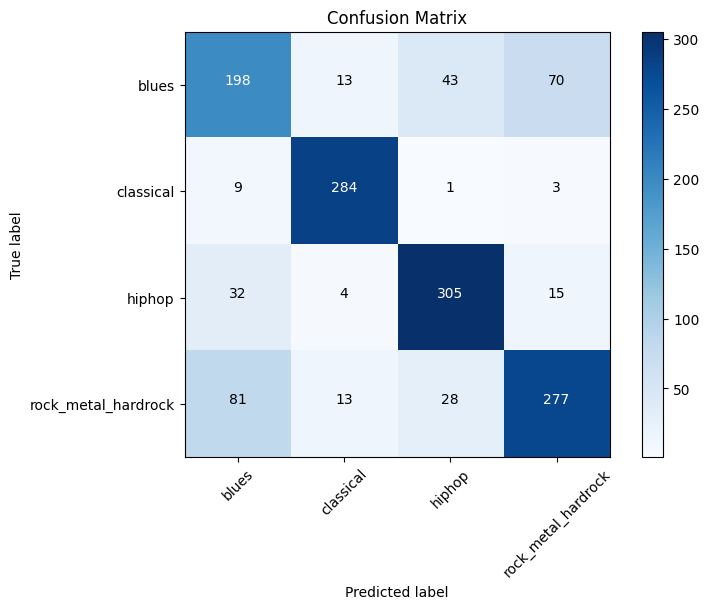

In [ ]:
weight_decay_value = 1e-3
results['weight_decay_value'].append(weight_decay_value)

# Scheduler selection
scheduler_name = 'ReduceLROnPlateau'
scheduler_class = torch.optim.lr_scheduler.ReduceLROnPlateau

# Device Selection
current_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(20*'*'+f'Training while using {current_device} with {weight_decay_value} weight_decay_value'+20*'*')

# Initiallizing the Neural Network
model = CNN_BatchNorm().to(current_device)
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate, weight_decay=weight_decay_value)
scheduler = scheduler_class(optimizer, mode='min', patience=3, factor=0.1, verbose=True)
print(model)

# Model Training
best_model = NN_Training(num_epochs, optimizer, train_dataloader, loss_fn, model,
                         current_device, validation=True, val_dataloader=val_dataloader, scheduler=scheduler)

# Model Testing
accuracy, f1 = NN_testing(test_dataloader, loss_fn, best_model, current_device, return_metrics=True)
results['Accuracy'].append(accuracy)
results['Macro F1'].append(f1)

********************Training while using cuda with 0.01 weight_decay_value********************
CNN_BatchNorm(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dense1): Linear(in_features=1024, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  (

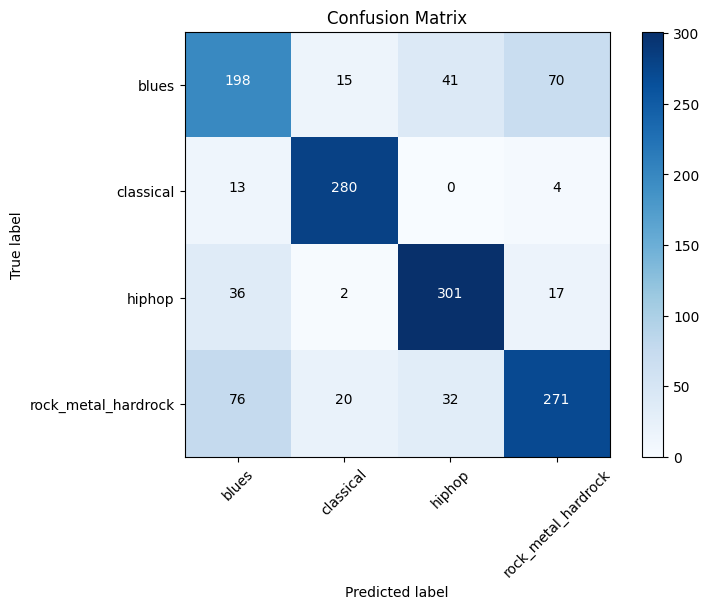

In [ ]:
weight_decay_value = 1e-2
results['weight_decay_value'].append(weight_decay_value)

# Scheduler selection
scheduler_name = 'ReduceLROnPlateau'
scheduler_class = torch.optim.lr_scheduler.ReduceLROnPlateau

# Device Selection
current_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(20*'*'+f'Training while using {current_device} with {weight_decay_value} weight_decay_value'+20*'*')

# Initiallizing the Neural Network
model = CNN_BatchNorm().to(current_device)
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate, weight_decay=weight_decay_value)
scheduler = scheduler_class(optimizer, mode='min', patience=3, factor=0.1, verbose=True)
print(model)

# Model Training
best_model = NN_Training(num_epochs, optimizer, train_dataloader, loss_fn, model,
                         current_device, validation=True, val_dataloader=val_dataloader, scheduler=scheduler)

# Model Testing
accuracy, f1 = NN_testing(test_dataloader, loss_fn, best_model, current_device, return_metrics=True)
results['Accuracy'].append(accuracy)
results['Macro F1'].append(f1)

In [ ]:
results_df = pd.DataFrame(results)
# Invert columns and rows
inverted_results = results_df.transpose()
print('\n'+20*'-'+f'Final results'+20*'-')
print(inverted_results)


--------------------Final results--------------------
                           0         1         2
weight_decay_value  0.000100  0.001000  0.010000
Accuracy            0.765262  0.773256  0.763081
Macro F1            0.765425  0.775464  0.765247


We notice that the most significant performance increase on the test set is achieved with a weight decay value of 1e-3, as the macro F1 score improved from 76.5% to 77.5%. Weight decay, or L2 regularization, helps prevent overfitting by penalizing large weights and promoting simpler, more generalizable patterns. This optimal balance between regularization and model flexibility likely contributed to the observed improvement.

### Dropout Introduction

In [ ]:
class Final_CNN(nn.Module):
    def __init__(self, dropout):
        super(Final_CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, 5, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 5, padding=2)
        self.bn4 = nn.BatchNorm2d(128)

        self.max_pool = nn.MaxPool2d(2)

        self.dense1 = nn.Linear(128 * 1 * 8, 1024)
        self.dense2 = nn.Linear(1024, 256)
        self.dense3 = nn.Linear(256, 32)
        self.dense4 = nn.Linear(32, 4)

        self.act_fn = nn.SELU()
        self.dropout = dropout

    def forward(self, x):
        x = self.max_pool(self.act_fn(self.bn1(self.conv1(x))))
        x = self.max_pool(self.act_fn(self.bn2(self.conv2(x))))
        x = self.max_pool(self.act_fn(self.bn3(self.conv3(x))))
        x = self.max_pool(self.act_fn(self.bn4(self.conv4(x))))

        x = x.view(x.size(0), -1)

        x = self.act_fn(self.dropout(self.dense1(x)))
        x = self.act_fn(self.dropout(self.dense2(x)))
        x = self.act_fn(self.dropout(self.dense3(x)))
        x = self.dense4(x)

        return x

In [ ]:
# Searching space
dropout_values = [0.1, 0.2, 0.3, 0.4, 0.5]

results = {
        'dropout_value': [],
        'Accuracy': [],
        'Macro F1': []
    }

********************Training while using cuda with 0.1 dropout_value********************
Final_CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dense1): Linear(in_features=1024, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  (dense3): L

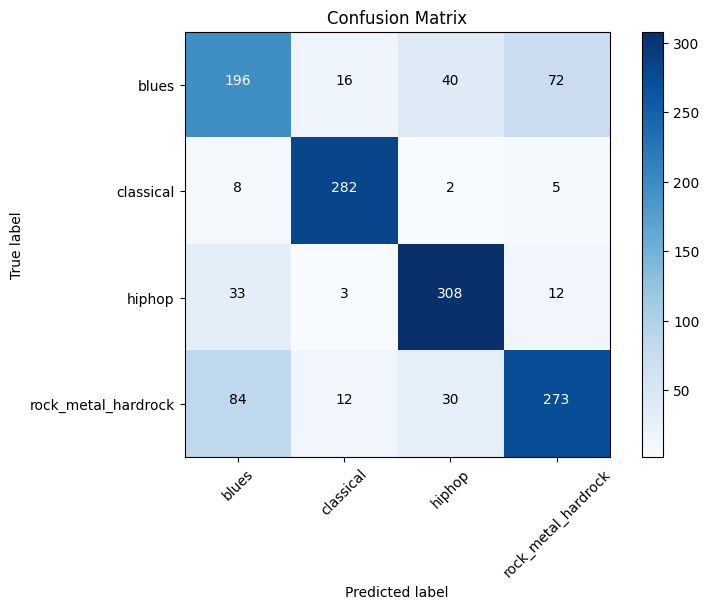

In [ ]:
dropout = 0.1
results['dropout_value'].append(dropout)

# Scheduler selection
scheduler_name = 'ReduceLROnPlateau'
scheduler_class = torch.optim.lr_scheduler.ReduceLROnPlateau

# Device Selection
current_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(20*'*'+f'Training while using {current_device} with {dropout} dropout_value'+20*'*')

# Initiallizing the Neural Network
model = Final_CNN(nn.Dropout(p=dropout)).to(current_device)
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)
scheduler = scheduler_class(optimizer, mode='min', patience=3, factor=0.1, verbose=True)
print(model)

# Model Training
best_model = NN_Training(num_epochs, optimizer, train_dataloader, loss_fn, model,
                         current_device, validation=True, val_dataloader=val_dataloader, scheduler=scheduler)

# Model Testing
accuracy, f1 = NN_testing(test_dataloader, loss_fn, best_model, current_device, return_metrics=True)
results['Accuracy'].append(accuracy)
results['Macro F1'].append(f1)

********************Training while using cuda with 0.2 dropout_value********************
Final_CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dense1): Linear(in_features=1024, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  (dense3): L

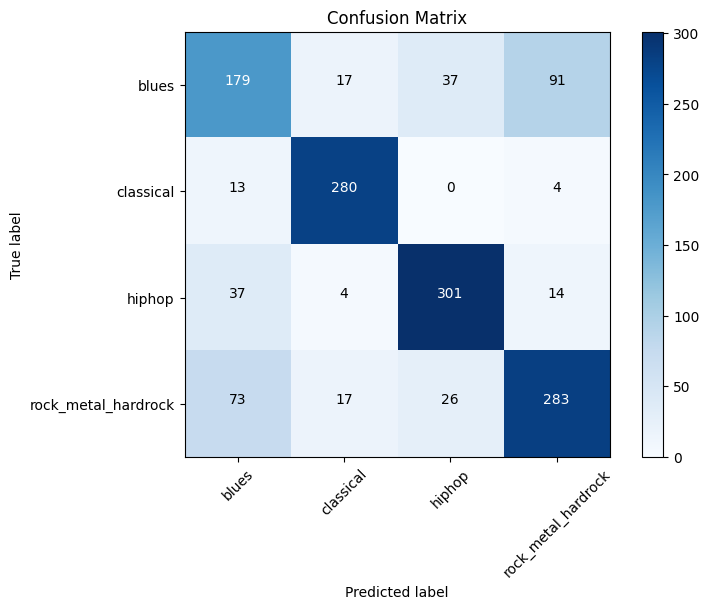

In [ ]:
dropout = 0.2
results['dropout_value'].append(dropout)

# Scheduler selection
scheduler_name = 'ReduceLROnPlateau'
scheduler_class = torch.optim.lr_scheduler.ReduceLROnPlateau

# Device Selection
current_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(20*'*'+f'Training while using {current_device} with {dropout} dropout_value'+20*'*')

# Initiallizing the Neural Network
model = Final_CNN(nn.Dropout(p=dropout)).to(current_device)
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)
scheduler = scheduler_class(optimizer, mode='min', patience=3, factor=0.1, verbose=True)
print(model)

# Model Training
best_model = NN_Training(num_epochs, optimizer, train_dataloader, loss_fn, model,
                         current_device, validation=True, val_dataloader=val_dataloader, scheduler=scheduler)

# Model Testing
accuracy, f1 = NN_testing(test_dataloader, loss_fn, best_model, current_device, return_metrics=True)
results['Accuracy'].append(accuracy)
results['Macro F1'].append(f1)

********************Training while using cuda with 0.3 dropout_value********************
Final_CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dense1): Linear(in_features=1024, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  (dense3): L

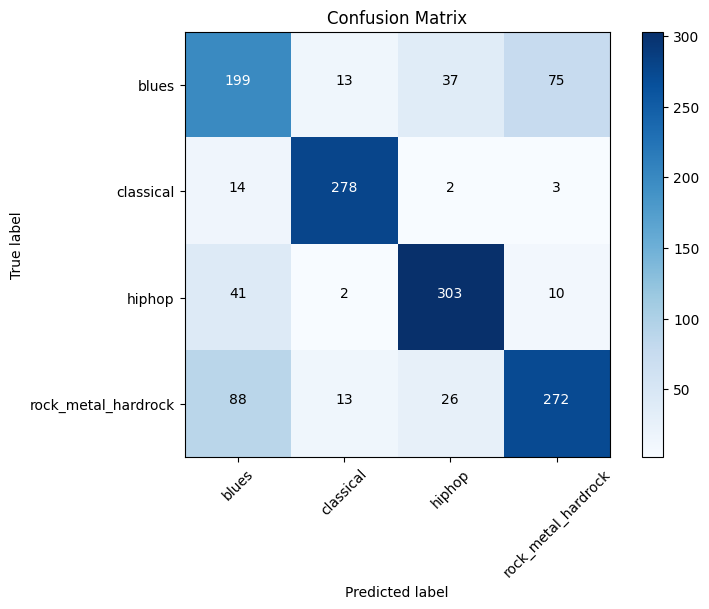

In [ ]:
dropout = 0.3
results['dropout_value'].append(dropout)

# Scheduler selection
scheduler_name = 'ReduceLROnPlateau'
scheduler_class = torch.optim.lr_scheduler.ReduceLROnPlateau

# Device Selection
current_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(20*'*'+f'Training while using {current_device} with {dropout} dropout_value'+20*'*')

# Initiallizing the Neural Network
model = Final_CNN(nn.Dropout(p=dropout)).to(current_device)
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)
scheduler = scheduler_class(optimizer, mode='min', patience=3, factor=0.1, verbose=True)
print(model)

# Model Training
best_model = NN_Training(num_epochs, optimizer, train_dataloader, loss_fn, model,
                         current_device, validation=True, val_dataloader=val_dataloader, scheduler=scheduler)

# Model Testing
accuracy, f1 = NN_testing(test_dataloader, loss_fn, best_model, current_device, return_metrics=True)
results['Accuracy'].append(accuracy)
results['Macro F1'].append(f1)

********************Training while using cuda with 0.4 dropout_value********************
Final_CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dense1): Linear(in_features=1024, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  (dense3): L

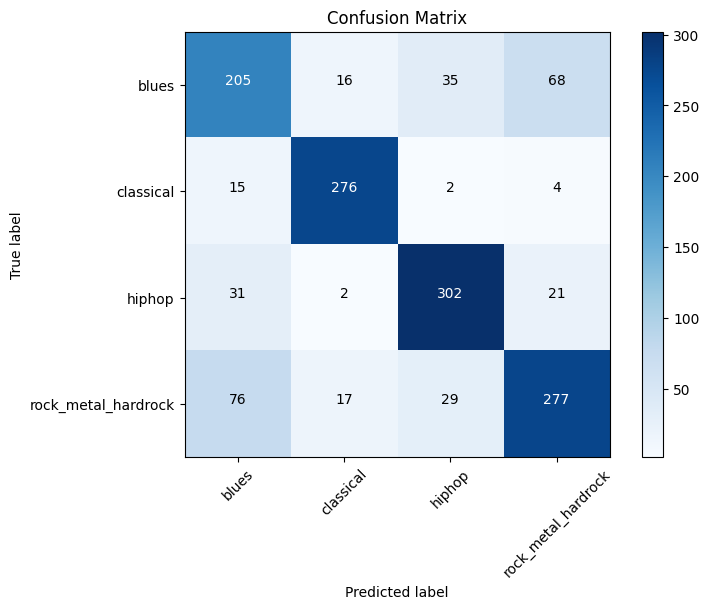

In [ ]:
dropout = 0.4
results['dropout_value'].append(dropout)

# Scheduler selection
scheduler_name = 'ReduceLROnPlateau'
scheduler_class = torch.optim.lr_scheduler.ReduceLROnPlateau

# Device Selection
current_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(20*'*'+f'Training while using {current_device} with {dropout} dropout_value'+20*'*')

# Initiallizing the Neural Network
model = Final_CNN(nn.Dropout(p=dropout)).to(current_device)
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)
scheduler = scheduler_class(optimizer, mode='min', patience=3, factor=0.1, verbose=True)
print(model)

# Model Training
best_model = NN_Training(num_epochs, optimizer, train_dataloader, loss_fn, model,
                         current_device, validation=True, val_dataloader=val_dataloader, scheduler=scheduler)

# Model Testing
accuracy, f1 = NN_testing(test_dataloader, loss_fn, best_model, current_device, return_metrics=True)
results['Accuracy'].append(accuracy)
results['Macro F1'].append(f1)

********************Training while using cuda with 0.5 dropout_value********************
Final_CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dense1): Linear(in_features=1024, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  (dense3): L

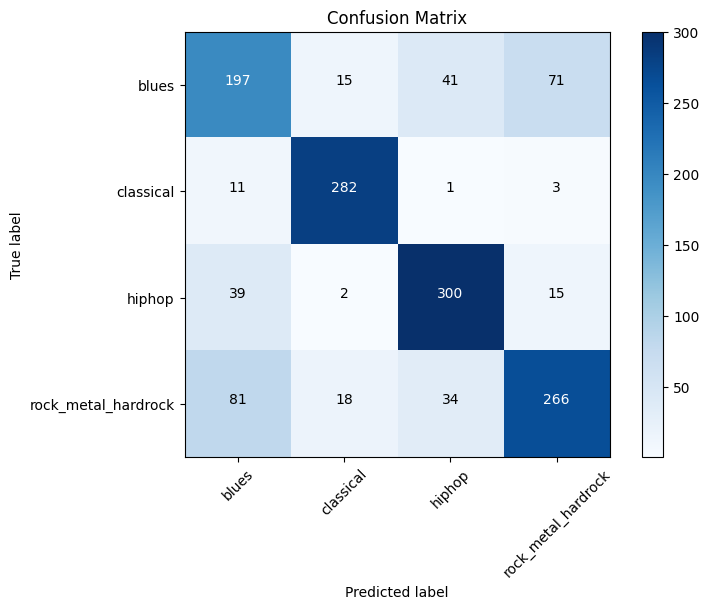

In [ ]:
dropout = 0.5
results['dropout_value'].append(dropout)

# Scheduler selection
scheduler_name = 'ReduceLROnPlateau'
scheduler_class = torch.optim.lr_scheduler.ReduceLROnPlateau

# Device Selection
current_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(20*'*'+f'Training while using {current_device} with {dropout} dropout_value'+20*'*')

# Initiallizing the Neural Network
model = Final_CNN(nn.Dropout(p=dropout)).to(current_device)
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)
scheduler = scheduler_class(optimizer, mode='min', patience=3, factor=0.1, verbose=True)
print(model)

# Model Training
best_model = NN_Training(num_epochs, optimizer, train_dataloader, loss_fn, model,
                         current_device, validation=True, val_dataloader=val_dataloader, scheduler=scheduler)

# Model Testing
accuracy, f1 = NN_testing(test_dataloader, loss_fn, best_model, current_device, return_metrics=True)
results['Accuracy'].append(accuracy)
results['Macro F1'].append(f1)

In [ ]:
results_df = pd.DataFrame(results)
# Invert columns and rows
inverted_results = results_df.transpose()
print('\n'+20*'-'+f'Final results'+20*'-')
print(inverted_results)


--------------------Final results--------------------
                      0         1         2         3         4
dropout_value  0.100000  0.200000  0.300000  0.400000  0.500000
Accuracy       0.769622  0.757994  0.764535  0.770349  0.759448
Macro F1       0.771694  0.758529  0.768351  0.773091  0.762026


We found that among the various dropout values tested, the most significant improvement on the test set occurred with a dropout rate of 0.4, increasing performance from 76.5% to 77.3%. A dropout rate of 0.4 indicates that there is a 40% probability that the output of each neuron will be ignored during training, which aids in closing the generalization gap and enhancing model robustness.

### Combination

We experimented with all the possible combinations and found out that the best perfoming model is achieved with a dropout value of 0.3 and a weight decay value of 1e-4.

********************Training while using cuda with 0.3 dropout value and 0.0001 weight decay value********************
Final_CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dense1): Linear(in_features=1024, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features

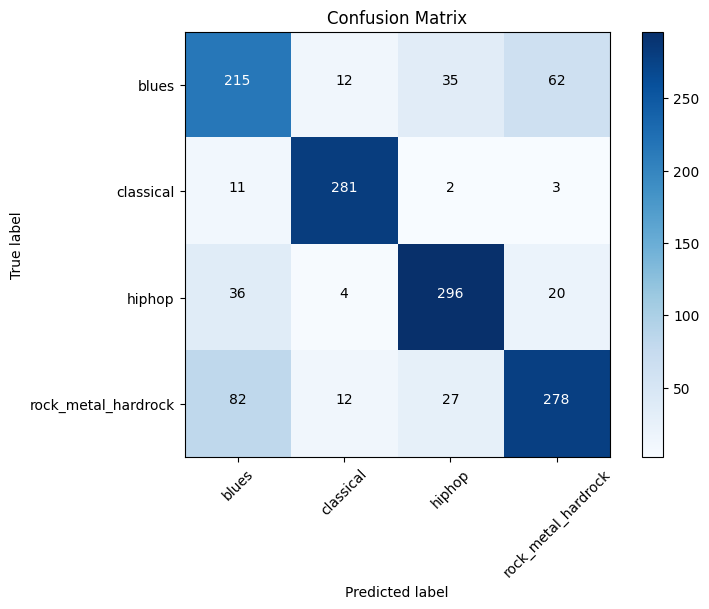

In [ ]:
dropout = 0.3
weight_decay = 1e-4
# Scheduler selection
scheduler_name = 'ReduceLROnPlateau'
scheduler_class = torch.optim.lr_scheduler.ReduceLROnPlateau

# Device Selection
current_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(20*'*'+f'Training while using {current_device} with {dropout} dropout value and {weight_decay} weight decay value'+20*'*')

# Initiallizing the Neural Network
model = Final_CNN(nn.Dropout(p=dropout)).to(current_device)
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate, weight_decay = weight_decay)
scheduler = scheduler_class(optimizer, mode='min', patience=3, factor=0.1, verbose=True)
print(model)

# Model Training
final_model = NN_Training(num_epochs, optimizer, train_dataloader, loss_fn, model,
                         current_device, validation=True, val_dataloader=val_dataloader, scheduler=scheduler)

# Model Testing
NN_testing(test_dataloader, loss_fn, final_model, current_device)

The macro F1 score on the test set has reached 78.2%, marking the highest performance achieved so far, which designates this model as our final choice. It's important to note the potential benefit of incorporating early stopping, given our observation that the F1 score on the validation set stabilizes well before reaching 60 epochs.

In [ ]:
# Define a file path to save the model
model_path = '/content/final_model.pth'

# Save the entire model
torch.save(final_model, model_path)

# Question 4: Testing

In this section, we will use our final model to make predictions for songs from YouTube. First, we download a song from YouTube that belongs to one of the four categories: blues, classical, hiphop, or rock/metal/hardrock, saving it in WAV format. Next, we compute a sequence of mel spectrograms, generating one spectrogram for each second of recorded music. Finally, we process the data using the same methods employed before the training of our final CNN model, and for every second of recorded music we predict the music genre of the given song.

Loading the final model.

In [ ]:
model_path = '/content/final_model.pth'
final_model = torch.load(model_path)

## Functions

In [ ]:
def Data_YouTubeloading(label):
    path = '/content/youtube_melgrams.npy'
    X_file = os.path.join(path)
    X_np = np.load(X_file)
    X_tensor = torch.tensor(X_np, dtype=torch.float32)
    Y_tensor = torch.full((X_tensor.shape[0],), label)
    print(f'X shape: {X_tensor.shape}')
    print(f'Y shape: {Y_tensor.shape}')
    return X_tensor, Y_tensor

def Data_Preparation(label):
    X_test, Y_test = Data_YouTubeloading(label) # Data Loading
    X_test = matrix_normalizer(X_test, 'melgrams') # Normalizing
    X_test = X_test.unsqueeze(1) # Adding a channel dimension

    # Loading to a Pytorch DataLoader
    testset = TensorDataset(X_test, Y_test)
    test_dataloader = DataLoader(testset, batch_size=16, shuffle=False)

    print('Shape of the input data: [number of samples, channels, height, width]')
    print(f'X_test shape: {X_test.shape}')
    return test_dataloader, Y_test

def Inference(model, dataloader, current_device):
    size = len(dataloader.dataset)
    correct_preds = 0
    preds, labels = [], []
    model.eval()
    with torch.no_grad():
        for X, Y in dataloader:
            X = X.to(current_device)
            Y = Y.to(current_device)
            pred = model(X)
            correct_preds += (pred.argmax(1) == Y).type(torch.float).sum().item()
            preds.extend(pred.argmax(1).tolist())
            labels.extend(Y.tolist())

    accuracy = correct_preds / size
    f1_test = f1_score(labels , preds, average='macro')
    print(20*"-"+f"Test Results"+20*"-"+"\n")
    print(f"Accuracy: {(100*accuracy):>0.1f}%, macro f1 score: {f1_test:>4f} \n")
    return preds

def plot_predictions(preds, labels, song, category_names):
    timestamps = range(len(preds))
    plt.scatter(timestamps, preds, s=1)
    plt.yticks(range(len(category_names)), category_names, rotation=45)
    plt.ylim(-0.1, len(category_names) - 0.9)
    plt.title(f'Predictions for {song}')
    plt.xlabel("timestamps")
    plt.ylabel("Labels")
    plt.show()

## YouTube to melgramm

In [ ]:
def download_youtube(youtube_url, output_path="output.wav"):
    yt = YouTube(youtube_url)
    stream = yt.streams.filter(only_audio=True).first()
    audio_file = stream.download(filename='downloaded_audio')

    # Step 4: Convert the audio file to .wav format using pydub
    audio = AudioSegment.from_file(audio_file)
    audio.export(output_path, format="wav")

    # Clean up the downloaded file
    os.remove(audio_file)

window_length = (50 * 1e-3)
hop_length = (50 * 1e-3)
mel_time_size = 21

def load_wav(filename):
    """Rea audio file and return audio signal and sampling frequency"""
    if not os.path.exists(filename):
        raise FileNotFoundError
    # Load file using librosa
    x, fs = librosa.load(filename, sr=None)
    return x, fs


def melspectrogram(x=None, fs=None, n_fft=None, hop_length=None,
                   fuse=False):
    """Returns a mel spectrogram."""

    if x is None:
        return None
    # Set some values
    if n_fft is None:
        n_fft = int(window_length * fs)
    if hop_length is None:
        hop_length = int(hop_length * fs)
    # Get spectrogram
    spectrogram = librosa.feature.melspectrogram(y=x, sr=fs, n_fft=n_fft,
                                                 hop_length=hop_length)
    # Convert to MEL-Scale
    spectrogram_dB = librosa.power_to_db(spectrogram, ref=np.max)  # (n_mel,t)

    if fuse:
        chroma = librosa.feature.chroma_stft(y=x, sr=fs, n_fft=n_fft,
                                             hop_length=hop_length)
        chroma_dB = librosa.power_to_db(chroma)
        out = np.concatenate((spectrogram_dB.T, chroma_dB.T), axis=1)
    else:
        # Transpose to return (time,n_mel)
        out = spectrogram_dB.T
    return out


def get_melgrams(file):
    signal, fs = load_wav(file)

    segment_length = int((mel_time_size - 1) * window_length * fs)
    sequence_length = signal.shape[0]
    progress = 0
    segments = []
    while progress < sequence_length:
        if progress + segment_length > sequence_length:
            fill_data = sequence_length - progress
            empty_data = segment_length - fill_data
            feature = melspectrogram(
                np.pad(signal[progress:], (0, empty_data), 'constant'),
                fs=fs, n_fft=int(window_length * fs), hop_length=int(hop_length * fs))
            segments.append(feature)
        else:
            feature = melspectrogram(
                signal[progress:progress + segment_length],
                fs=fs, n_fft=int(window_length * fs), hop_length=int(hop_length * fs))

            segments.append(feature)
        progress += segment_length

    return segments


def youtube_to_melgram(url):
    download_youtube(url)
    melgrams = get_melgrams("output.wav")
    np.save("youtube_melgrams.npy", melgrams)

## Testing the final model on YouTube songs

In [ ]:
category_names = ['blues', 'classical', 'hiphop', 'rock_metal_hardrock']

BB King: How Blue Can You Get - Gerne: Blues

X shape: torch.Size([314, 20, 128])
Y shape: torch.Size([314])
Shape of the input data: [number of samples, channels, height, width]
X_test shape: torch.Size([314, 1, 20, 128])
--------------------Test Results--------------------

Accuracy: 5.7%, macro f1 score: 0.036145 



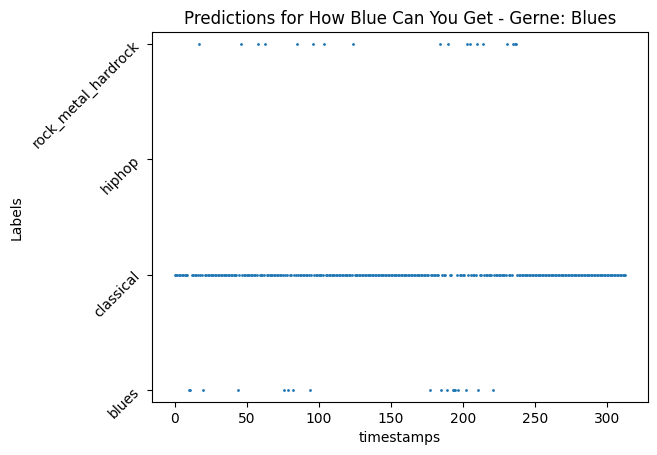

In [ ]:
youtube_to_melgram('https://www.youtube.com/watch?v=l45f28PzfCI')
song = 'How Blue Can You Get - Gerne: Blues'

test_dataloader, Y_test = Data_Preparation(label=0)

predictions = Inference(final_model, test_dataloader, current_device=torch.device("cuda"))
plot_predictions(predictions, Y_test, song, category_names)

Chopin - Nocturne op.9 No.2 - Gerne: Classical

X shape: torch.Size([270, 20, 128])
Y shape: torch.Size([270])
Shape of the input data: [number of samples, channels, height, width]
X_test shape: torch.Size([270, 1, 20, 128])
--------------------Test Results--------------------

Accuracy: 98.5%, macro f1 score: 0.496269 



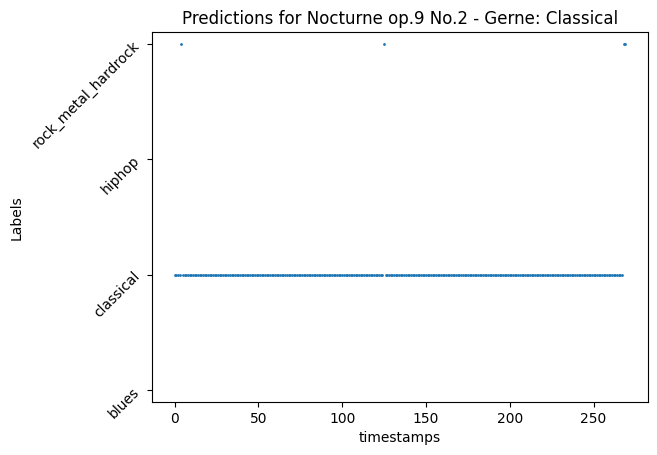

In [ ]:
youtube_to_melgram('https://www.youtube.com/watch?v=9E6b3swbnWg')
song = 'Nocturne op.9 No.2 - Gerne: Classical'

test_dataloader, Y_test = Data_Preparation(label=1)

predictions = Inference(final_model, test_dataloader, current_device=torch.device("cuda"))
plot_predictions(predictions, Y_test, song, category_names)

50 cent: In Da Club - Gerne: hip hop

X shape: torch.Size([248, 20, 128])
Y shape: torch.Size([248])
Shape of the input data: [number of samples, channels, height, width]
X_test shape: torch.Size([248, 1, 20, 128])
--------------------Test Results--------------------

Accuracy: 14.1%, macro f1 score: 0.082450 



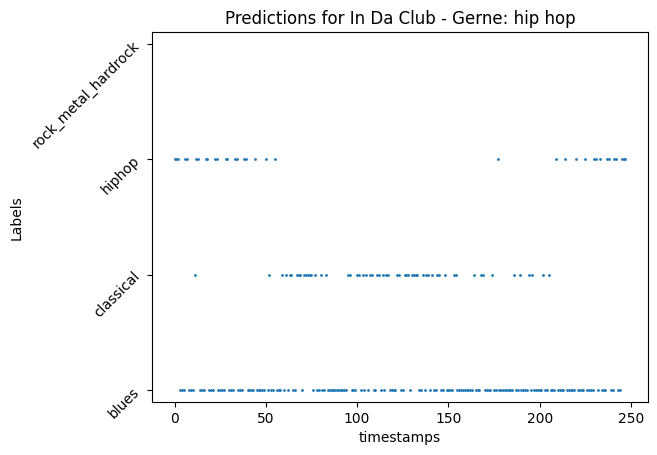

In [ ]:
youtube_to_melgram('https://www.youtube.com/watch?v=5qm8PH4xAss')
song = 'In Da Club - Gerne: hip hop'

test_dataloader, Y_test = Data_Preparation(label=2)

predictions = Inference(final_model, test_dataloader, current_device=torch.device("cuda"))
plot_predictions(predictions, Y_test, song, category_names)

ACDC: T.N.T. - Gerne: Rock

X shape: torch.Size([215, 20, 128])
Y shape: torch.Size([215])
Shape of the input data: [number of samples, channels, height, width]
X_test shape: torch.Size([215, 1, 20, 128])
--------------------Test Results--------------------

Accuracy: 2.3%, macro f1 score: 0.015152 



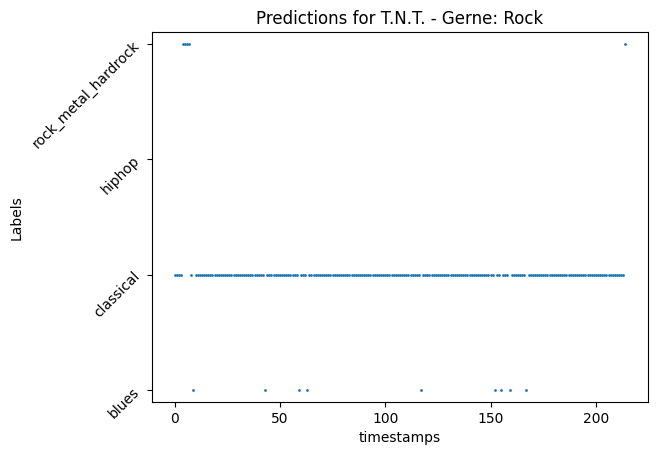

In [ ]:
youtube_to_melgram('https://www.youtube.com/watch?v=NhsK5WExrnE')
song = 'T.N.T. - Gerne: Rock'

test_dataloader, Y_test = Data_Preparation(label=3)

predictions = Inference(final_model, test_dataloader, current_device=torch.device("cuda"))
plot_predictions(predictions, Y_test, song, category_names)

We observe a significant drop in performance here compared to our test set, indicating that our model struggles with generalization. Specifically, there appears to be a bias towards predicting the music genre 'classical' for many timestamps in YouTube songs, regardless of whether they truly belong to that genre. This prompts us to reconsider the quality of our dataset. It's essential to assess whether our dataset provides sufficient diversity and representativeness for our model to generalize effectively to real-world songs on YouTube. If our dataset is deemed adequate, further optimizations within our CNN architecture should be explored.